In [13]:
import math
from datetime import datetime, timedelta

import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow

In [2]:
client = mlflow.MlflowClient(tracking_uri="http://127.0.0.1:5000")

"""
exp_desc_2 = (
    "Optimizing Apple Classifier Project w/ optuna"
)

exp_tags_2 = {
    "project_name" : "apple-models-optuna",
    "mlflow.note.content": exp_desc_2
}

try:
    apple_experiment_2 = client.create_experiment(name="Apple_Models_Optuna", tags=exp_tags_2)
except Exception as e:
    print(f"Error Occured: {e}")
    apple_experiment_2 = mlflow.set_experiment("Apple_Models_Optuna")
"""


'\nexp_desc_2 = (\n    "Optimizing Apple Classifier Project w/ optuna"\n)\n\nexp_tags_2 = {\n    "project_name" : "apple-models-optuna",\n    "mlflow.note.content": exp_desc_2\n}\n\ntry:\n    apple_experiment_2 = client.create_experiment(name="Apple_Models_Optuna", tags=exp_tags_2)\nexcept Exception as e:\n    print(f"Error Occured: {e}")\n    apple_experiment_2 = mlflow.set_experiment("Apple_Models_Optuna")\n'

# Data Preparation

### Generate synthetic training data

In [3]:
def generate_apple_sales_data_with_promo_adjustment(
    base_demand: int = 1000,
    n_rows: int = 5000,
    competitor_price_effect: float = -50.0,
):
    """
    Generates a synthetic dataset for predicting apple sales demand with multiple
    influencing factors.

    This function creates a pandas DataFrame with features relevant to apple sales.
    The features include date, average_temperature, rainfall, weekend flag, holiday flag,
    promotional flag, price_per_kg, competitor's price, marketing intensity, stock availability,
    and the previous day's demand. The target variable, 'demand', is generated based on a
    combination of these features with some added noise.

    Args:
        base_demand (int, optional): Base demand for apples. Defaults to 1000.
        n_rows (int, optional): Number of rows (days) of data to generate. Defaults to 5000.
        competitor_price_effect (float, optional): Effect of competitor's price being lower
                                                   on our sales. Defaults to -50.

    Returns:
        pd.DataFrame: DataFrame with features and target variable for apple sales prediction.

    Example:
        >>> df = generate_apple_sales_data_with_promo_adjustment(base_demand=1200, n_rows=6000)
        >>> df.head()
    """

    # Set seed for reproducibility
    np.random.seed(9999)

    # Create date range
    dates = [datetime.now() - timedelta(days=i) for i in range(n_rows)]
    dates.reverse()

    # Generate features
    df = pd.DataFrame(
        {
            "date": dates,
            "average_temperature": np.random.uniform(10, 35, n_rows),
            "rainfall": np.random.exponential(5, n_rows),
            "weekend": [(date.weekday() >= 5) * 1 for date in dates],
            "holiday": np.random.choice([0, 1], n_rows, p=[0.97, 0.03]),
            "price_per_kg": np.random.uniform(0.5, 3, n_rows),
            "month": [date.month for date in dates],
        }
    )

    # Introduce inflation over time (years)
    df["inflation_multiplier"] = 1 + (df["date"].dt.year - df["date"].dt.year.min()) * 0.03

    # Incorporate seasonality due to apple harvests
    df["harvest_effect"] = np.sin(2 * np.pi * (df["month"] - 3) / 12) + np.sin(
        2 * np.pi * (df["month"] - 9) / 12
    )

    # Modify the price_per_kg based on harvest effect
    df["price_per_kg"] = df["price_per_kg"] - df["harvest_effect"] * 0.5

    # Adjust promo periods to coincide with periods lagging peak harvest by 1 month
    peak_months = [4, 10]  # months following the peak availability
    df["promo"] = np.where(
        df["month"].isin(peak_months),
        1,
        np.random.choice([0, 1], n_rows, p=[0.85, 0.15]),
    )

    # Generate target variable based on features
    base_price_effect = -df["price_per_kg"] * 50
    seasonality_effect = df["harvest_effect"] * 50
    promo_effect = df["promo"] * 200

    df["demand"] = (
        base_demand
        + base_price_effect
        + seasonality_effect
        + promo_effect
        + df["weekend"] * 300
        + np.random.normal(0, 50, n_rows)
    ) * df["inflation_multiplier"]  # adding random noise

    # Add previous day's demand
    df["previous_days_demand"] = df["demand"].shift(1)
    df["previous_days_demand"] = df["previous_days_demand"].bfill()  # fill the first row

    # Introduce competitor pricing
    df["competitor_price_per_kg"] = np.random.uniform(0.5, 3, n_rows)
    df["competitor_price_effect"] = (
        df["competitor_price_per_kg"] < df["price_per_kg"]
    ) * competitor_price_effect

    # Stock availability based on past sales price (3 days lag with logarithmic decay)
    log_decay = -np.log(df["price_per_kg"].shift(3) + 1) + 2
    df["stock_available"] = np.clip(log_decay, 0.7, 1)

    # Marketing intensity based on stock availability
    # Identify where stock is above threshold
    high_stock_indices = df[df["stock_available"] > 0.95].index

    # For each high stock day, increase marketing intensity for the next week
    for idx in high_stock_indices:
        df.loc[idx : min(idx + 7, n_rows - 1), "marketing_intensity"] = np.random.uniform(0.7, 1)

    # If the marketing_intensity column already has values, this will preserve them;
    #  if not, it sets default values
    fill_values = pd.Series(np.random.uniform(0, 0.5, n_rows), index=df.index)
    df["marketing_intensity"] = df["marketing_intensity"].fillna(fill_values)

    # Adjust demand with new factors
    df["demand"] = df["demand"] + df["competitor_price_effect"] + df["marketing_intensity"]

    # Drop temporary columns
    df.drop(
        columns=[
            "inflation_multiplier",
            "harvest_effect",
            "month",
            "competitor_price_effect",
            "stock_available",
        ],
        inplace=True,
    )

    return df


In [4]:
df = generate_apple_sales_data_with_promo_adjustment(base_demand=1_000, n_rows=5000)
df


,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity
0,2011-02-13 12:10:17.839237,30.584727,1.199291,1,0,1.726258,0,1151.375336,1151.276659,1.935346,0.098677
1,2011-02-14 12:10:17.839237,15.465069,1.037626,0,0,0.576471,0,906.855943,1151.276659,2.344720,0.019318
2,2011-02-15 12:10:17.839237,10.786525,5.656089,0,0,2.513328,0,808.304909,906.836626,0.998803,0.409485
3,2011-02-16 12:10:17.839237,23.648154,12.030937,0,0,1.839225,0,799.833810,857.895424,0.761740,0.872803
4,2011-02-17 12:10:17.839237,13.861391,4.303812,0,0,1.531772,0,983.949061,848.961007,2.123436,0.820779
...,...,...,...,...,...,...,...,...,...,...,...
4995,2024-10-17 12:10:17.833735,21.643051,3.821656,0,0,2.391010,1,1418.210762,1424.064082,1.504432,0.756489
4996,2024-10-18 12:10:17.833735,13.808813,1.080603,0,1,0.898693,1,1563.149505,1467.454273,1.343586,0.742145
4997,2024-10-19 12:10:17.833735,11.698227,1.911000,1,0,2.839860,1,1660.171368,1562.407359,2.771896,0.742145
4998,2024-10-20 12:10:17.833735,18.052081,1.000521,1,0,1.188440,1,2063.369501,1709.429223,2.564075,0.742145


### Data Visualization

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation_with_demand(df, save_path=None):  # noqa: D417
    """
    Plots the correlation of each variable in the dataframe with the 'demand' column.

    Args:
    - df (pd.DataFrame): DataFrame containing the data, including a 'demand' column.
    - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

    Returns:
    - None (Displays the plot on a Jupyter window)
    """

    # Compute correlations between all variables and 'demand'
    correlations = df.corr()["demand"].drop("demand").sort_values()

    # Generate a color palette from red to green
    colors = sns.diverging_palette(10, 130, as_cmap=True)
    color_mapped = correlations.map(colors)

    # Set Seaborn style
    sns.set_style(
        "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
    )  # Light grey background and thicker grid lines

    # Create bar plot
    fig = plt.figure(figsize=(12, 8))
    plt.barh(correlations.index, correlations.values, color=color_mapped)

    # Set labels and title with increased font size
    plt.title("Correlation with Demand", fontsize=18)
    plt.xlabel("Correlation Coefficient", fontsize=16)
    plt.ylabel("Variable", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="x")

    plt.tight_layout()

    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # prevent matplotlib from displaying the chart every time we call this function
    plt.close(fig)

    return fig


# Test the function
correlation_plot = plot_correlation_with_demand(df, save_path="correlation_plot.png")


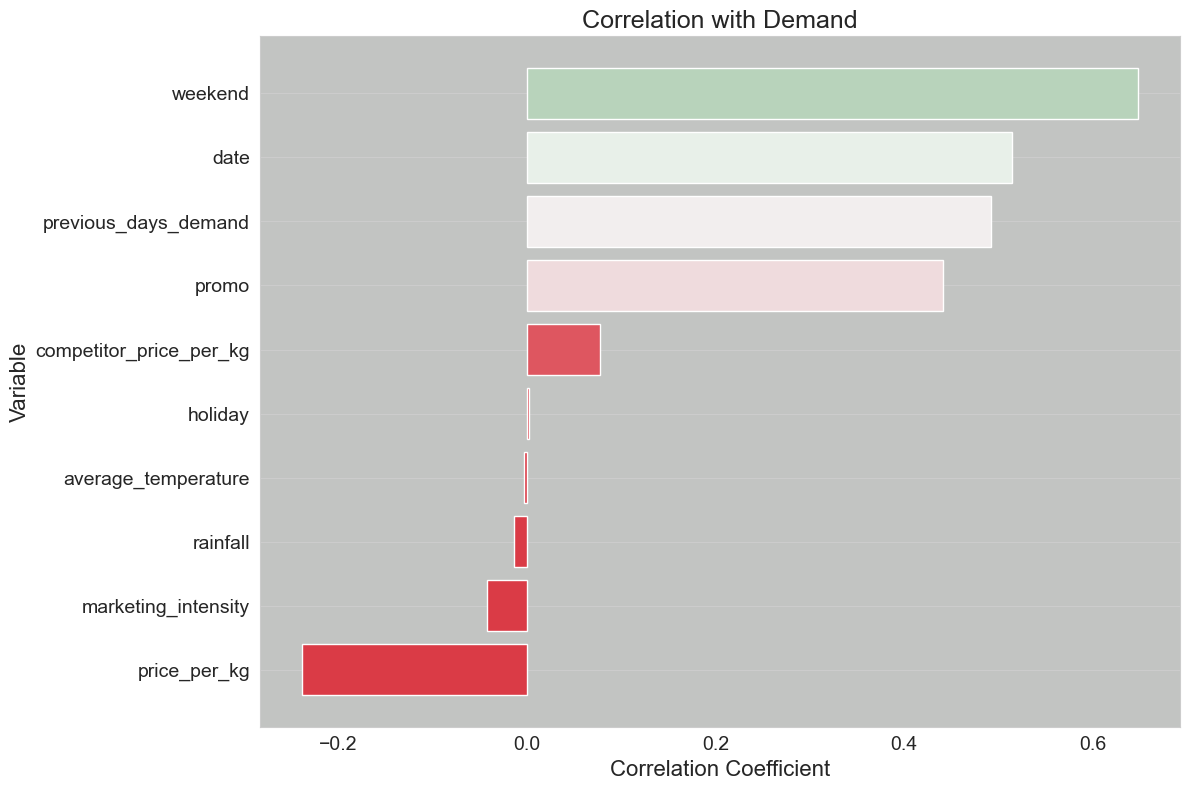

In [6]:
correlation_plot

In [7]:
def plot_residuals(model, dvalid, valid_y, save_path=None):  # noqa: D417
    """
    Plots the residuals of the model predictions against the true values.

    Args:
    - model: The trained XGBoost model.
    - dvalid (xgb.DMatrix): The validation data in XGBoost DMatrix format.
    - valid_y (pd.Series): The true values for the validation set.
    - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

    Returns:
    - None (Displays the residuals plot on a Jupyter window)
    """

    # Predict using the model
    preds = model.predict(dvalid)

    # Calculate residuals
    residuals = valid_y - preds

    # Set Seaborn style
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

    # Create scatter plot
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(valid_y, residuals, color="blue", alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="-")

    # Set labels, title and other plot properties
    plt.title("Residuals vs True Values", fontsize=18)
    plt.xlabel("True Values", fontsize=16)
    plt.ylabel("Residuals", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y")

    plt.tight_layout()

    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # Show the plot
    plt.close(fig)

    return fig


In [8]:
def plot_feature_importance(model, booster):  # noqa: D417
    """
    Plots feature importance for an XGBoost model.

    Args:
    - model: A trained XGBoost model

    Returns:
    - fig: The matplotlib figure object
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    importance_type = "weight" if booster == "gblinear" else "gain"
    xgb.plot_importance(
        model,
        importance_type=importance_type,
        ax=ax,
        title=f"Feature Importance based on {importance_type}",
    )
    plt.tight_layout()
    plt.close(fig)

    return fig

# MLflow Experiment

In [23]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)

In [24]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
experiment_id = get_or_create_experiment("Apple_Classifier_Optuna")
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='mlflow-artifacts:/805675939520470692', creation_time=1729477760849, experiment_id='805675939520470692', last_update_time=1729477760849, lifecycle_stage='active', name='Apple_Classifier_Optuna', tags={}>

In [25]:
X = df.drop(columns=["date", "demand"])
y = df["demand"]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

### Hyperparameter Tuning and Model Training using Optuna and MLflow

In [26]:
# Override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Define a logging callback that will report on only new challenger parameter 
# configurations if a trial has surpassed the state of 'best conditions'

def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)
    if study.best_value and winner != study.best_value:
       study.set_user_attr("winner", study.best_value)
       if winner:
        improvement_percent = (abs(winner-study.best_value) / study.best_value) * 100
        print(
            f"Trial {frozen_trial.number} achieved value: {frozen_trial.value}"
            f"Improvement %: {improvement_percent}"
        )
    else:
        print(f"Initial Trial {frozen_trial.number} achieved value: {frozen_trial.value}")


In [27]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "objective": "reg:squarederror", # Loss Function
            "eval_metric": "rmse",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }

        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )
        
        # Train XGBoost Model
        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        error = root_mean_squared_error(valid_y, preds)

        # Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("mse", error**2)
        mlflow.log_metric("rmse", error)

    return error


In [28]:
run_name = "first_attempt"

In [29]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name=run_name,
    nested=True
):
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=500, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mse", study.best_value**2)
    mlflow.log_metric("best_rmse", study.best_value)

    # LOG Tags
    mlflow.set_tags(
        tags={
            "project": "Apple Demand Project using Optuna",
            "optimizer_engine": "optuna",
            "model_family": "xgboost",
            "feature_set_verison": 1,
        }
    )

    # Log a fit model instance
    model = xgb.train(study.best_params, dtrain)

    # Log the correlation plot
    mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")

    # Log the feature importances plot
    importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")

    # Log the residuals plot
    residuals = plot_residuals(model, dvalid, valid_y)
    mlflow.log_figure(figure=residuals, artifact_file="residuals.png")

    artifact_path = "model"

    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=train_x.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)

2024/10/21 13:51:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run honorable-jay-491 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1da4a93133434bfdaf1d39d3f4f852a8.
2024/10/21 13:51:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.
2024/10/21 13:51:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-quail-744 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e2da4afbd5b34fea80a0ccc9dfbafe4d.
2024/10/21 13:51:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 1 achieved value: 243.26999416559818


2024/10/21 13:51:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-shark-227 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ede6d5bf1d0c4597a93a7d96f9729e33.
2024/10/21 13:51:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 2 achieved value: 139.85598471967944


2024/10/21 13:51:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run clumsy-cat-904 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e54de9aab25c45848383bbf8bb974e4e.
2024/10/21 13:51:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 3 achieved value: 149.7732828018714


2024/10/21 13:51:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-lamb-189 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/33ffafbb272f43ccb7e4ac8402125f5a.
2024/10/21 13:51:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 4 achieved value: 243.27008824682366


2024/10/21 13:51:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run upset-snake-49 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f3e81e44c568488f97fc6431a2ef5d77.
2024/10/21 13:51:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 5 achieved value: 203.64197297283


2024/10/21 13:51:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run blushing-newt-799 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/694ece20ff434c58ad567a8a4725deba.
2024/10/21 13:51:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 6 achieved value: 140.27375451477585


2024/10/21 13:51:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run incongruous-gull-730 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ad129a5bc4264535bd1c71755105d8a3.
2024/10/21 13:51:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 7 achieved value: 243.2703888678084


2024/10/21 13:51:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run lyrical-lamb-356 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/246ec12241d64e07bb77ad26a344a383.
2024/10/21 13:51:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 8 achieved value: 207.52985187642778


2024/10/21 13:51:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-bug-895 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/9075284a31af4d1da1dd34e330d7f315.
2024/10/21 13:51:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 9 achieved value: 138.61045978475238Improvement %: 0.19845158064100252


2024/10/21 13:51:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run powerful-moth-880 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/736140da6d074d499d771bb5c09b4454.
2024/10/21 13:51:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 10 achieved value: 207.43584509980695


2024/10/21 13:51:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-wasp-45 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/040056d288c048aaa714152065eef98d.
2024/10/21 13:51:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 11 achieved value: 138.61152254527718


2024/10/21 13:51:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run intelligent-hog-112 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/52c7d9990d004b848ea720407cbd11af.
2024/10/21 13:51:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 12 achieved value: 143.1899108914877


2024/10/21 13:51:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run intelligent-fish-455 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5a7f4c46d24b4d4da840f6f0c7ac0600.
2024/10/21 13:51:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 13 achieved value: 143.36098931975715


2024/10/21 13:51:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-stoat-536 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c92504abbe004ac4b30e04e87b71b012.
2024/10/21 13:51:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 14 achieved value: 243.22141258142346


2024/10/21 13:51:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-stoat-718 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4e5f74c168e14b5b8437b97e4d59fcf6.
2024/10/21 13:51:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 15 achieved value: 141.8938915587317


2024/10/21 13:51:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-owl-899 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b5a025662bd64097bafc893e88520aa7.
2024/10/21 13:51:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 16 achieved value: 139.31980595600103


2024/10/21 13:51:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-swan-645 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/444e9d8858c346bfbff8447944226dfc.
2024/10/21 13:51:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 17 achieved value: 141.41890833452865


2024/10/21 13:51:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-bat-747 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ca56d69439c342b0801a460e18ab3d34.
2024/10/21 13:51:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 18 achieved value: 243.06769789018668


2024/10/21 13:51:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run gaudy-vole-953 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/9cdb76c04639485e90ea3491691d181a.
2024/10/21 13:51:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 19 achieved value: 146.55552901910085


2024/10/21 13:51:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run angry-moth-88 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/52c7bc7ed97a4567b1b181f5eebfb469.
2024/10/21 13:51:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 20 achieved value: 193.6036384966771


2024/10/21 13:51:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run delightful-mouse-376 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b584d5fcc9c9401bade9760b1d00bd1e.
2024/10/21 13:51:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 21 achieved value: 143.33308503478065


2024/10/21 13:51:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run dapper-kite-195 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/24dc004f9c9947dab7af5f8a24f40ce7.
2024/10/21 13:51:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 22 achieved value: 140.728823062351


2024/10/21 13:51:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run painted-fox-247 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/98f35df4a7d448b4b832cb20a5f387f7.
2024/10/21 13:51:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 23 achieved value: 139.16818917617147


2024/10/21 13:51:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run righteous-flea-893 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/591dfb25546d44369eccfb0bf345fed3.
2024/10/21 13:51:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 24 achieved value: 143.36033428973877


2024/10/21 13:51:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run chill-duck-478 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/905adb0e1c624de9b7719602a82765c3.
2024/10/21 13:51:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 25 achieved value: 138.7923186200519


2024/10/21 13:51:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run smiling-midge-126 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a70666610ed242769ed499533cc05466.
2024/10/21 13:51:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 26 achieved value: 141.2202517037458


2024/10/21 13:51:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-ray-182 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/abf21b302b1441d9889c87f5a52e17aa.
2024/10/21 13:51:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 27 achieved value: 137.6038825115077Improvement %: 0.7315035410868644


2024/10/21 13:51:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-eel-226 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7f8be458efc342a7b31fda27667cfea1.
2024/10/21 13:51:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 28 achieved value: 243.23274475367054


2024/10/21 13:51:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run skillful-sloth-551 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a142447fd1a1472fb779c7e23fbf1f8e.
2024/10/21 13:51:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 29 achieved value: 240.56965507930465


2024/10/21 13:51:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-lark-398 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/041714deacb64abab53ea54ea8ddcf7d.
2024/10/21 13:51:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 30 achieved value: 143.36103771462246


2024/10/21 13:51:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-cub-19 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/93d105308154478798d15e366023e2ae.
2024/10/21 13:51:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 31 achieved value: 137.57699923056356Improvement %: 0.01954053446032803


2024/10/21 13:51:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-frog-400 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/91ea544898144d5d962527b8e39c285d.
2024/10/21 13:51:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 32 achieved value: 143.35870255114023


2024/10/21 13:51:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run stylish-pig-226 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d9183ea626144577bcdb371646b730c6.
2024/10/21 13:51:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 33 achieved value: 143.36088975476716


2024/10/21 13:51:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run masked-elk-314 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/be54c37b5b1a4238a80e8f34f64c57e8.
2024/10/21 13:51:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 34 achieved value: 141.3700956644009


2024/10/21 13:52:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-fawn-598 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/197b92fd365b406faf8d3e7f1fd84fa2.
2024/10/21 13:52:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 35 achieved value: 143.36009541006786


2024/10/21 13:52:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run valuable-loon-857 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3a0bcde323044be3ba6c01c4a3ca6519.
2024/10/21 13:52:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 36 achieved value: 243.2656231076206


2024/10/21 13:52:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-crab-514 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/75e9fb59491449c1a9490aa5ef97249b.
2024/10/21 13:52:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 37 achieved value: 139.35414696048886


2024/10/21 13:52:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-gnu-378 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6b320e72cee0408c9234551a74319dac.
2024/10/21 13:52:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 38 achieved value: 139.78056356652067


2024/10/21 13:52:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite-deer-625 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/44035ee2ff314c4faef933a15ab4bfbb.
2024/10/21 13:52:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 39 achieved value: 141.31544401650646


2024/10/21 13:52:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-bass-469 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/8739f2bab1784f52818a50e542959941.
2024/10/21 13:52:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 40 achieved value: 240.79197052182894


2024/10/21 13:52:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-hawk-23 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e77d51990bba43da8130ba82dea55f2f.
2024/10/21 13:52:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 41 achieved value: 143.36082671597856


2024/10/21 13:52:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run unequaled-snail-705 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d51613d5483a4ff09d6c931d45868fb2.
2024/10/21 13:52:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 42 achieved value: 138.0194375715003


2024/10/21 13:52:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run invincible-bug-370 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c357a1ad551140bbb8b70ee73ba0af25.
2024/10/21 13:52:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 43 achieved value: 139.358147530452


2024/10/21 13:52:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run stylish-cub-282 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/397eb3911a96445f96bc51c8dde46eb3.
2024/10/21 13:52:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 44 achieved value: 143.36078778789846


2024/10/21 13:52:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-stoat-279 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/615425d8a1d145c980e307b4e9968b61.
2024/10/21 13:52:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 45 achieved value: 143.35537737974244


2024/10/21 13:52:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run welcoming-seal-103 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/abdfd9e0e7924d77b3644bdc337d4b8e.
2024/10/21 13:52:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 46 achieved value: 139.3479436107807


2024/10/21 13:52:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run painted-moth-798 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/100ec47e07ee4f7c8b5a7383ad60905d.
2024/10/21 13:52:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 47 achieved value: 139.8164635584206


2024/10/21 13:52:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run silent-finch-269 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0615b5f741804cf48f0e30661a7ceddd.
2024/10/21 13:52:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 48 achieved value: 142.1267212421357


2024/10/21 13:52:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run grandiose-tern-763 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5ca13b3054ec45e18fef3b55347405f3.
2024/10/21 13:52:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 49 achieved value: 243.2677284705736


2024/10/21 13:52:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-bug-647 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/fc8639b3aa73420b9b74325bc580e4d7.
2024/10/21 13:52:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 50 achieved value: 148.65890535103588


2024/10/21 13:52:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-shrew-456 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3ce721718b56405c80d234095ce05c18.
2024/10/21 13:52:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 51 achieved value: 142.4587425822425


2024/10/21 13:52:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-goat-371 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e469aa08dd194223aa90ca41474ba56f.
2024/10/21 13:52:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 52 achieved value: 140.56020931639492


2024/10/21 13:52:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-ox-132 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/fa0da481dfff4698b94ed011ad4be4db.
2024/10/21 13:52:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 53 achieved value: 143.36037430072446


2024/10/21 13:52:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-slug-982 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5a85c80a5fb24caea79f64f5ad6213c3.
2024/10/21 13:52:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 54 achieved value: 139.3944215498492


2024/10/21 13:52:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run loud-hog-90 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/bd4a39f2df964c68b1c0cf77611014f8.
2024/10/21 13:52:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 55 achieved value: 143.36094060157905


2024/10/21 13:52:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-crane-195 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6685d69f8e344a038ae7bf2a7d02936a.
2024/10/21 13:52:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 56 achieved value: 198.65572340596734


2024/10/21 13:52:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-bass-737 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ef1c86f0eb084a1b9e713fe48d73b473.
2024/10/21 13:52:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 57 achieved value: 138.83977506699685


2024/10/21 13:52:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run silent-slug-554 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/9148d1d39c8846f285715b2f0f9c6a04.
2024/10/21 13:52:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 58 achieved value: 143.35781908810642


2024/10/21 13:52:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run placid-cod-450 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2e03108cb23b4d4fbe9a8c7162eb3034.
2024/10/21 13:52:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 59 achieved value: 243.2703888678084


2024/10/21 13:52:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-loon-931 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/86a83d459a1a40d9a0bc7c86477c7297.
2024/10/21 13:52:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 60 achieved value: 143.35574833959936


2024/10/21 13:52:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run judicious-loon-435 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3439f145e00f4383b715dc934ef8a6ca.
2024/10/21 13:52:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 61 achieved value: 143.3599556040622


2024/10/21 13:52:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run unruly-squirrel-307 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e0b9ab81ec8a4332a8f27cc449b516fc.
2024/10/21 13:52:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 62 achieved value: 143.3607989497735


2024/10/21 13:52:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-ram-717 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3ed986d4837e492bbf30542c5ead7a99.
2024/10/21 13:52:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 63 achieved value: 139.50836544223637


2024/10/21 13:52:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run rebellious-loon-34 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c45c0b9e789d4fa497d0dd6ae5dbf2c1.
2024/10/21 13:52:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 64 achieved value: 142.94805186238074


2024/10/21 13:52:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-crow-701 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/aa173a793cb141ad852159f4d0b241d9.
2024/10/21 13:52:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 65 achieved value: 143.35958627278157


2024/10/21 13:52:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run flawless-shrew-71 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/fbca60b8f5ae49ae925216a872bd8c99.
2024/10/21 13:52:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 66 achieved value: 139.32747419852876


2024/10/21 13:52:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run dazzling-perch-481 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e5c6307503534593b8129180e6966f71.
2024/10/21 13:52:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 67 achieved value: 143.3608735216772


2024/10/21 13:52:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run indecisive-steed-269 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3cb269250ab14e26b490d874f4f13a1c.
2024/10/21 13:52:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 68 achieved value: 242.36746582037705


2024/10/21 13:52:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-worm-143 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/97a291a1ea124314bb469bbcd817a6be.
2024/10/21 13:52:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 69 achieved value: 138.81698883788943


2024/10/21 13:52:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-elk-188 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b93706292e7741dd8d7c1f8c641d1e87.
2024/10/21 13:52:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 70 achieved value: 180.63102399612345


2024/10/21 13:52:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run unruly-yak-554 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ea0c5f0a6f7d4cd481d0d96558004594.
2024/10/21 13:52:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 71 achieved value: 139.55130945406398


2024/10/21 13:52:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run indecisive-mink-985 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3d82b86d268b4c5fbcfb73fdd5b7f607.
2024/10/21 13:52:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 72 achieved value: 139.34615531534922


2024/10/21 13:52:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run funny-colt-283 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5b703dacdbaf41c1b1497a15790b4adb.
2024/10/21 13:52:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 73 achieved value: 138.73734152874073


2024/10/21 13:52:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run delicate-shark-902 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ea7b5a21b9e9414481aa96ef3dcf5c2f.
2024/10/21 13:52:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 74 achieved value: 139.98593126707544


2024/10/21 13:52:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-shrew-473 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/00cf0072a0814659b693404787355e51.
2024/10/21 13:52:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 75 achieved value: 143.3368120950755


2024/10/21 13:52:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-carp-424 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/14904fea6f964c729365109e50e4fee0.
2024/10/21 13:52:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 76 achieved value: 243.2590585532806


2024/10/21 13:52:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-shrimp-967 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/21c6acf87bde478bbd93caa90f56219f.
2024/10/21 13:52:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 77 achieved value: 138.27127468784363


2024/10/21 13:52:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-newt-496 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4ac8183d7698450da577369ded9f4019.
2024/10/21 13:52:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 78 achieved value: 140.46681582194003


2024/10/21 13:52:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run thoughtful-auk-949 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3d1b0cfe63c149c58985494bdffabe43.
2024/10/21 13:52:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 79 achieved value: 139.13711217432729


2024/10/21 13:52:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-rook-513 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/82893055143e45c59287adbc14e01200.
2024/10/21 13:52:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 80 achieved value: 135.03788579343677Improvement %: 1.8802970901149838


2024/10/21 13:52:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run inquisitive-bass-274 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/03da04fdb15e49009bfe2a70f2cfd1b0.
2024/10/21 13:52:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 81 achieved value: 136.86095917362502


2024/10/21 13:52:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-cod-964 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/929f983451cd42209d20c274a0690f16.
2024/10/21 13:52:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 82 achieved value: 138.99195520283482


2024/10/21 13:52:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run incongruous-slug-425 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7d66071fc822439fbe98bf6841808b99.
2024/10/21 13:52:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 83 achieved value: 233.25553059296462


2024/10/21 13:52:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run respected-rat-100 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/76983b419e524f2bb617fead1c002d9f.
2024/10/21 13:52:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 84 achieved value: 132.98451181862092Improvement %: 1.544070017429154


2024/10/21 13:52:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run monumental-yak-832 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/732bea90816644f1a79ff87b00652ddf.
2024/10/21 13:52:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 85 achieved value: 151.55016819833224


2024/10/21 13:52:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run blushing-koi-707 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/19ae09b5ade94b34a4017b8488c0e5ec.
2024/10/21 13:52:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 86 achieved value: 134.43927091869574


2024/10/21 13:52:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-tern-901 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/9c09c7dac25f4c46a7a7a95b21b1ac72.
2024/10/21 13:52:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 87 achieved value: 128.43356573513384Improvement %: 3.5434242267106466


2024/10/21 13:52:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run fearless-shrew-680 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1134263d84b44e38a7f3e7abf2602f96.
2024/10/21 13:52:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 88 achieved value: 129.92277944355993


2024/10/21 13:52:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-squid-676 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ad19cd0d0b3f4dde9cc1857ed1faec09.
2024/10/21 13:52:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 89 achieved value: 129.12333174852319


2024/10/21 13:52:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-croc-494 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5a6a3c446240404ebaa32778dcd64381.
2024/10/21 13:52:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 90 achieved value: 128.36500057358Improvement %: 0.053414218242871084


2024/10/21 13:52:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run hilarious-gnat-281 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1a17cfd0ae914ba78d7e0e6899b0041e.
2024/10/21 13:52:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 91 achieved value: 128.7361590607711


2024/10/21 13:52:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run bright-robin-421 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a491982f25794a9fac32b2c1b363242f.
2024/10/21 13:52:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 92 achieved value: 129.37241327649258


2024/10/21 13:52:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run traveling-gull-522 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f125ac595a7844008883d2fca329c0ec.
2024/10/21 13:52:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 93 achieved value: 128.55493945621086


2024/10/21 13:52:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-rat-816 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/8304b209c69347498638c68c36be3a75.
2024/10/21 13:52:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 94 achieved value: 129.04124852760506


2024/10/21 13:52:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run brawny-roo-193 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1db05c981cc448e9a72401f230c35c66.
2024/10/21 13:52:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 95 achieved value: 131.17417354657678


2024/10/21 13:52:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-gull-397 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ff995d1013d847ebb9fc682f66e3d6b7.
2024/10/21 13:52:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 96 achieved value: 132.80648608621803


2024/10/21 13:52:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run adventurous-vole-103 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1558732d897a42d1be07c9559806fd86.
2024/10/21 13:52:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 97 achieved value: 138.11508649608723


2024/10/21 13:52:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-dog-104 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a515d1b554b146aebd906ec148f5df39.
2024/10/21 13:52:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 98 achieved value: 130.27430347095725


2024/10/21 13:52:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run useful-bug-548 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ef27be9ebe88413bbdf690fde3557848.
2024/10/21 13:52:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 99 achieved value: 151.60814690144295


2024/10/21 13:52:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-slug-24 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3c3675257e2549ee811f98a4972998f3.
2024/10/21 13:52:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 100 achieved value: 129.1065352095614


2024/10/21 13:52:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run merciful-squid-680 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0fd4158625fd471393aab29ff06e9f06.
2024/10/21 13:52:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 101 achieved value: 130.95646198231125


2024/10/21 13:52:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run bald-mule-793 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5b10bd7483294499b6a46fd0ed131089.
2024/10/21 13:52:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 102 achieved value: 175.63328727645558


2024/10/21 13:52:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run popular-croc-486 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e65f90f60d85431b9edbf677d29e64a4.
2024/10/21 13:52:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 103 achieved value: 128.07476246355967Improvement %: 0.22661616109022228


2024/10/21 13:52:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-lark-666 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a3ae976072824c0cb8159a9d2576a2cb.
2024/10/21 13:52:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 104 achieved value: 128.1091253595544


2024/10/21 13:52:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run useful-squirrel-976 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/636c062813d44d5d881fe3a65efe4253.
2024/10/21 13:52:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 105 achieved value: 162.7788605658296


2024/10/21 13:52:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-cat-587 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c7cea1453b08427dbd38ccc1775afd27.
2024/10/21 13:52:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 106 achieved value: 128.18585868086544


2024/10/21 13:52:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run skittish-hound-928 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b4c71e7dc62d4a42833480226ad2e796.
2024/10/21 13:52:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 107 achieved value: 218.78161496474777


2024/10/21 13:52:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-gnat-25 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/246ba33872d843f488948b4e3718186f.
2024/10/21 13:52:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 108 achieved value: 125.30685691161182Improvement %: 2.208901907020345


2024/10/21 13:52:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-whale-168 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/26288f99dab848eaba03adaee0758676.
2024/10/21 13:52:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 109 achieved value: 172.5410447472415


2024/10/21 13:52:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run sedate-cub-123 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/090d64890e494036b9d2b1ff1924b37b.
2024/10/21 13:52:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 110 achieved value: 149.19786081177983


2024/10/21 13:52:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-quail-262 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/fb1aa08b22ad4b08b5a59c525141e095.
2024/10/21 13:52:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 111 achieved value: 128.1228653764001


2024/10/21 13:52:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run blushing-stoat-368 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d3f5d88407a74c72add554ae7f69ca5c.
2024/10/21 13:52:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 112 achieved value: 128.57058131379912


2024/10/21 13:52:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run angry-toad-726 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/67b06ad43a394b908e5cda3102e2fc0b.
2024/10/21 13:52:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 113 achieved value: 127.24806991932132


2024/10/21 13:52:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run stately-sponge-2 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/97fe7f97a1e3465c9fca9e9bfa314bef.
2024/10/21 13:52:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 114 achieved value: 130.77652400005013


2024/10/21 13:52:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-doe-241 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b7cfb2e47a9e4d158fc8af40cec6d3db.
2024/10/21 13:52:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 115 achieved value: 162.89806235069528


2024/10/21 13:52:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run awesome-panda-983 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5b66fa085df34948a45301f6b8ae71de.
2024/10/21 13:52:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 116 achieved value: 124.95513469343673Improvement %: 0.28147880360258465


2024/10/21 13:52:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-fawn-641 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4ceb2a82ca4e4da2868eb7f15330ff64.
2024/10/21 13:52:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 117 achieved value: 130.21558531116682


2024/10/21 13:52:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run smiling-newt-359 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/06cbf83d0b27408ba29a2c313b2a63d9.
2024/10/21 13:52:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 118 achieved value: 208.5605893398934


2024/10/21 13:52:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run whimsical-skunk-347 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f97f4cf5b3e5486c9624f1efe344f479.
2024/10/21 13:52:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 119 achieved value: 143.63988404539657


2024/10/21 13:52:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run unique-auk-213 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a11e156277ff495b83af32c923e47dbc.
2024/10/21 13:52:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 120 achieved value: 141.26322255797487


2024/10/21 13:52:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run classy-crab-141 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/07c116e796954cb1a2e50fcd804833ee.
2024/10/21 13:52:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 121 achieved value: 125.61357221140427


2024/10/21 13:52:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run bemused-flea-634 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b5b66bcebfb348308fd4c45d7373b117.
2024/10/21 13:52:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 122 achieved value: 125.19559837441852


2024/10/21 13:52:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-mule-101 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e6ce660543c544ada786ef30081f9da1.
2024/10/21 13:52:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 123 achieved value: 126.13153507854081


2024/10/21 13:52:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run mysterious-newt-334 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/84b4332a098f4cd19a1c3b8bd91cc9e3.
2024/10/21 13:52:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 124 achieved value: 125.92639099099017


2024/10/21 13:52:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-jay-472 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7a036a8a873e44859b8bb2f4bacbb0b8.
2024/10/21 13:52:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 125 achieved value: 127.54668131774426


2024/10/21 13:52:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run lyrical-trout-25 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/8a58bb498754498eb55d6fd4051700c0.
2024/10/21 13:52:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 126 achieved value: 126.24119254567599


2024/10/21 13:52:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run valuable-donkey-780 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7392cb40e99749c3b22a31b9cf88c296.
2024/10/21 13:52:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 127 achieved value: 129.07238959577336


2024/10/21 13:52:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run zealous-smelt-494 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/aff22d814239403cabc62561f51d04c8.
2024/10/21 13:52:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 128 achieved value: 142.14233876022314


2024/10/21 13:52:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-ant-691 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/95215e25513343668933d1cfdc5dae5d.
2024/10/21 13:52:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 129 achieved value: 124.83417249334931Improvement %: 0.0968983073075311


2024/10/21 13:52:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run selective-pug-380 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/dec79c17a898450cb25389b2bd88de80.
2024/10/21 13:52:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 130 achieved value: 125.16742995344657


2024/10/21 13:52:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-dolphin-880 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4f017e48f50c4431b8627697530b1d2d.
2024/10/21 13:52:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 131 achieved value: 125.17583809464497


2024/10/21 13:52:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run suave-fowl-953 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/88d401ff93454c2a884fb8b742fc8573.
2024/10/21 13:52:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 132 achieved value: 126.37641570475151


2024/10/21 13:52:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run intelligent-ray-412 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7af12bd66581418a881695ec11a27981.
2024/10/21 13:52:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 133 achieved value: 128.17607438474238


2024/10/21 13:52:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-snipe-34 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/396ef2a7ced4423796070ee2ff6d980d.
2024/10/21 13:52:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 134 achieved value: 126.74538053209393


2024/10/21 13:52:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-ox-684 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5e51a2fbcabc417081e6731fd4464758.
2024/10/21 13:52:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 135 achieved value: 126.5751420057022


2024/10/21 13:52:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-panda-799 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d10338491a7e4b7f8cd747b0524c1256.
2024/10/21 13:52:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 136 achieved value: 126.36469313683432


2024/10/21 13:52:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite-seal-324 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/cf6972cd236d4ec18252f3cf2f08bf15.
2024/10/21 13:52:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 137 achieved value: 130.03149543360985


2024/10/21 13:52:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-donkey-951 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1e650f18f62c4513a57eb6610ed3fb00.
2024/10/21 13:52:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 138 achieved value: 133.76383355890607


2024/10/21 13:52:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-wasp-101 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3130930d2dfc4fd7ac1a406ba60e42c6.
2024/10/21 13:52:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 139 achieved value: 125.134782749193


2024/10/21 13:52:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run valuable-dog-465 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/959a31b837d445e5b3805d77a253f782.
2024/10/21 13:52:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 140 achieved value: 141.87583379786486


2024/10/21 13:52:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run aged-deer-368 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4bc221d5be584351a451484d4ba87a84.
2024/10/21 13:52:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 141 achieved value: 125.04768977711323


2024/10/21 13:52:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite-gull-549 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2f65d61df6644012abfd86b82ed27d61.
2024/10/21 13:52:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 142 achieved value: 125.1922258603501


2024/10/21 13:52:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run dazzling-fish-38 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a93174a8f3534dec81ee4e1ffec2f2e6.
2024/10/21 13:52:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 143 achieved value: 124.81709142394625Improvement %: 0.013684880178024298


2024/10/21 13:52:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run whimsical-ox-361 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/49b4b6584db3417c85dd000cab955f22.
2024/10/21 13:52:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 144 achieved value: 140.46044065178842


2024/10/21 13:52:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run amazing-bee-951 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/31d41221e77443ab8e5131a86ae85206.
2024/10/21 13:52:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 145 achieved value: 124.36592426387249Improvement %: 0.3627739372695893


2024/10/21 13:52:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-turtle-893 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6a2f9633b99244f39c670e9217388971.
2024/10/21 13:52:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 146 achieved value: 243.2703888678084


2024/10/21 13:52:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-foal-839 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/cddc8e6b7159448dae66d79f40f4336f.
2024/10/21 13:52:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 147 achieved value: 126.19684458257278


2024/10/21 13:52:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-stoat-22 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b17fa8f79e04470680f0619c41ecb303.
2024/10/21 13:52:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 148 achieved value: 147.07829982566057


2024/10/21 13:52:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run adventurous-goat-690 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/253ce6e14c9a479caef8a4f93cccc5d5.
2024/10/21 13:52:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 149 achieved value: 167.25391661782558


2024/10/21 13:52:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run suave-zebra-219 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/abdf4dcc465348279c41b597370fcb39.
2024/10/21 13:52:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 150 achieved value: 242.95822694934728


2024/10/21 13:52:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run bustling-perch-930 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3ee1188731064dd2886043c719ed746c.
2024/10/21 13:52:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 151 achieved value: 126.35946611126099


2024/10/21 13:52:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run angry-bee-962 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/bfdd557b2a7048678af3184705ccdffa.
2024/10/21 13:52:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 152 achieved value: 124.51074231213295


2024/10/21 13:52:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run gaudy-ox-220 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/75b65bc0ef4545719ec7f712dbf436a4.
2024/10/21 13:52:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 153 achieved value: 124.68072832096055


2024/10/21 13:52:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run orderly-crow-970 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e18e41059a2a46b195b1dbb634fccdbb.
2024/10/21 13:52:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 154 achieved value: 124.51573832952741


2024/10/21 13:52:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-gull-57 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/db21a3f27a4c4b02a5ba8ca0ff2ccd62.
2024/10/21 13:52:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 155 achieved value: 131.15147931019126


2024/10/21 13:52:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run hilarious-carp-845 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/da31e647a3b34dfd86f00e4bbcc4154c.
2024/10/21 13:52:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 156 achieved value: 125.04978195199239


2024/10/21 13:52:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-fish-955 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7b44c4f2b8574dd18c312cfecd2a5b86.
2024/10/21 13:52:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 157 achieved value: 132.15876799017238


2024/10/21 13:52:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run indecisive-fly-270 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a58b26933985462589bb786fe7e5ca8a.
2024/10/21 13:52:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 158 achieved value: 124.78809889016648


2024/10/21 13:52:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run popular-eel-152 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d1a82ad7578647309a92fd09eb76070b.
2024/10/21 13:52:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 159 achieved value: 127.61569799034935


2024/10/21 13:52:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-chimp-975 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d8337450945b40fcadd8729da69b316b.
2024/10/21 13:52:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 160 achieved value: 151.83598202066312


2024/10/21 13:52:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run treasured-cod-309 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/13f8401b956d4281bf2534e5e83b1495.
2024/10/21 13:52:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 161 achieved value: 125.2473973384097


2024/10/21 13:52:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-turtle-880 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/24554693cad74010ae36656b5986f564.
2024/10/21 13:52:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 162 achieved value: 125.20408749780641


2024/10/21 13:52:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run skillful-hog-305 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d833977dd67141059041cba7b2d25d46.
2024/10/21 13:52:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 163 achieved value: 125.708538033747


2024/10/21 13:52:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-elk-428 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1640376ac826427f83f46c28f6ece0a7.
2024/10/21 13:52:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 164 achieved value: 130.541970861677


2024/10/21 13:52:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run unruly-lamb-347 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4aca065d47d34e17b0828ffe97492c67.
2024/10/21 13:52:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 165 achieved value: 130.0790489451245


2024/10/21 13:52:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-chimp-631 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/41d99e9e718043429c4a44646a7f533a.
2024/10/21 13:52:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 166 achieved value: 243.22319795806789


2024/10/21 13:52:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run rumbling-goose-644 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2cd5dbd7a6d94b16ac37a7391749b0a9.
2024/10/21 13:52:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 167 achieved value: 125.29716999771699


2024/10/21 13:52:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-snail-585 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/74ef6508bac2481fad04c8f472269a54.
2024/10/21 13:52:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 168 achieved value: 195.2566367966525


2024/10/21 13:52:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-ant-254 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/8c07038f37fb4b9bbb493fc29f484d96.
2024/10/21 13:52:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 169 achieved value: 240.86588481839075


2024/10/21 13:52:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run zealous-fowl-628 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b162218bd8db425ba20f71ad4f599b8a.
2024/10/21 13:52:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 170 achieved value: 126.6616539468993


2024/10/21 13:52:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run casual-dog-32 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/59af0c42c95b4cc0becfdf4f1a0cbfb2.
2024/10/21 13:52:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 171 achieved value: 124.81591126544107


2024/10/21 13:52:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run flawless-shad-578 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f7d4e40cf43d4f34a7977d8ec9de33a1.
2024/10/21 13:52:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 172 achieved value: 124.76545916546455


2024/10/21 13:52:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run magnificent-gnat-317 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d4f8886830da4351854be04e5af31e18.
2024/10/21 13:52:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 173 achieved value: 134.91139116810874


2024/10/21 13:52:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run burly-dolphin-37 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5c3e8bb0d6684d84b81cc89249cce67f.
2024/10/21 13:52:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 174 achieved value: 123.90045779328354Improvement %: 0.3756777649405767


2024/10/21 13:52:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run clumsy-fly-792 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/00ffb60d1303416c903fc649e546dc37.
2024/10/21 13:52:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 175 achieved value: 130.1808095793348


2024/10/21 13:52:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run painted-robin-408 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e223e7541519471fa51ef878c2df01d9.
2024/10/21 13:52:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 176 achieved value: 124.62777099840052


2024/10/21 13:52:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-hound-758 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/51771b5e32ac40feb4683cd3e2fbe10f.
2024/10/21 13:52:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 177 achieved value: 124.34581120449258


2024/10/21 13:52:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run bemused-cod-657 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/937c31df38bc4842a8e26add8f629f83.
2024/10/21 13:52:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 178 achieved value: 124.36910039127261


2024/10/21 13:52:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run gregarious-newt-953 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ba21034b939548fa9717324e8ede8c3a.
2024/10/21 13:52:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 179 achieved value: 129.61104209413813


2024/10/21 13:52:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-bug-692 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/edd7b26661a044d095e0f9805fbef464.
2024/10/21 13:52:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 180 achieved value: 123.90712055093488


2024/10/21 13:52:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run exultant-shoat-944 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/34ef399765b44cb589ef636c0ac707b5.
2024/10/21 13:52:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 181 achieved value: 124.61313558629173


2024/10/21 13:52:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-auk-688 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/16b137cd8c8843d4aeb80a79d43af903.
2024/10/21 13:52:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 182 achieved value: 124.7230368055722


2024/10/21 13:52:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-jay-576 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d65d720f541146f7821944a0cd967f57.
2024/10/21 13:52:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 183 achieved value: 124.37255321502987


2024/10/21 13:52:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-eel-742 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/72825363deec4a22ba4c2555ef37430d.
2024/10/21 13:52:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 184 achieved value: 141.06680841740015


2024/10/21 13:52:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-penguin-581 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0d949ec73bd04713b9b99e976af27ac9.
2024/10/21 13:52:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 185 achieved value: 124.47630750256117


2024/10/21 13:52:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-seal-268 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/42661fe7025c4c7db02d448453b2ccce.
2024/10/21 13:52:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 186 achieved value: 158.12985321187284


2024/10/21 13:52:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-deer-82 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b1e11ac16bd04027aae0b78eb93e8a22.
2024/10/21 13:52:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 187 achieved value: 125.90381521244645


2024/10/21 13:52:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run judicious-swan-187 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/92d15c22e90e4f049efdfa9089060b4d.
2024/10/21 13:52:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 188 achieved value: 127.14199076727735


2024/10/21 13:52:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run painted-stoat-648 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/322c694a5a6647d886dddbb4b200c0f9.
2024/10/21 13:52:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 189 achieved value: 243.2689594021976


2024/10/21 13:52:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-duck-876 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/cdf59b54c2a34ca1aee0d11ae4f1350f.
2024/10/21 13:52:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 190 achieved value: 124.34969873047156


2024/10/21 13:52:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run melodic-rat-694 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e7d1e8133ba84413bef30a0d87db6967.
2024/10/21 13:52:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 191 achieved value: 124.4822956567259


2024/10/21 13:52:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run learned-zebra-709 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5f9759966bd143a494781bac413e7fba.
2024/10/21 13:52:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 192 achieved value: 124.66188599136387


2024/10/21 13:52:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run powerful-sloth-346 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e0561ae0970249c9b6a4cc5f5a092d77.
2024/10/21 13:52:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 193 achieved value: 130.7474042659618


2024/10/21 13:53:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run marvelous-deer-853 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7f0b706d94544900955ee89928903abf.
2024/10/21 13:53:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 194 achieved value: 124.36360090281612


2024/10/21 13:53:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run rumbling-hog-945 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6a1647e6a09e4f73b8d48f160f2408af.
2024/10/21 13:53:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 195 achieved value: 124.59957826990863


2024/10/21 13:53:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run adventurous-bat-1 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/13b3170e4ae74f05b8c7f5d7f4740306.
2024/10/21 13:53:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 196 achieved value: 126.87115249753164


2024/10/21 13:53:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run gaudy-kit-253 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/27de1cbb21ec45849878c6099ae6aa1a.
2024/10/21 13:53:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 197 achieved value: 140.25616577830712


2024/10/21 13:53:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run placid-finch-237 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/de6699adbf8f4b3692dc396fef2b2122.
2024/10/21 13:53:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 198 achieved value: 127.83297073578076


2024/10/21 13:53:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-hound-700 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d7ef0ecf33d8494b900568b8d7c97d01.
2024/10/21 13:53:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 199 achieved value: 124.28547310136523


2024/10/21 13:53:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-wolf-4 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/15def1944d3742c8a41cdc07294d84bb.
2024/10/21 13:53:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 200 achieved value: 137.97445489701224


2024/10/21 13:53:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run treasured-lark-48 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2529959cdae044d49c971793bdd1b751.
2024/10/21 13:53:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 201 achieved value: 124.69605259176458


2024/10/21 13:53:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run inquisitive-roo-996 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ab88113f0a4944769f342b0e807ec553.
2024/10/21 13:53:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 202 achieved value: 124.77857250139445


2024/10/21 13:53:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run honorable-lark-844 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c96fe9ca9cbf4e059a7c9125b5f28ad0.
2024/10/21 13:53:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 203 achieved value: 127.4244175219906


2024/10/21 13:53:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run exultant-midge-711 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/83de4b05e8cd4de4a46d69c7a694191e.
2024/10/21 13:53:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 204 achieved value: 124.72324903087431


2024/10/21 13:53:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-kit-186 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ecc991eb386a4501a9f14df364ec4b73.
2024/10/21 13:53:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 205 achieved value: 124.35810738452355


2024/10/21 13:53:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-loon-749 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0dbfa87154694483b3b348ae941b82ce.
2024/10/21 13:53:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 206 achieved value: 128.1501762845982


2024/10/21 13:53:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-newt-42 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b20fd42c1e4c46f18779da8fb251c393.
2024/10/21 13:53:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 207 achieved value: 128.2925831037854


2024/10/21 13:53:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run flawless-duck-805 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e336919d89d146afb65ced3e796c9825.
2024/10/21 13:53:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 208 achieved value: 125.21604248763937


2024/10/21 13:53:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run invincible-wren-560 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1b72d5692c4c46faaa0abc1bc1424acd.
2024/10/21 13:53:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 209 achieved value: 136.16747362360513


2024/10/21 13:53:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run abundant-worm-84 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d72ef5251e8145478310e6e6795da9f0.
2024/10/21 13:53:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 210 achieved value: 153.6557574115487


2024/10/21 13:53:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run grandiose-pug-953 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3a5e7aaa5bce44558bad7e139d16105f.
2024/10/21 13:53:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 211 achieved value: 124.40506086076947


2024/10/21 13:53:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run popular-vole-612 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ac7af780589849e7ae0c9030521f2e71.
2024/10/21 13:53:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 212 achieved value: 127.13632096614805


2024/10/21 13:53:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-doe-356 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5f0362a2a72640139fdecf748e81b7cb.
2024/10/21 13:53:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 213 achieved value: 125.1320349228


2024/10/21 13:53:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-stag-536 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4a61407498c841cb99e07756ec5d0c45.
2024/10/21 13:53:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 214 achieved value: 127.33718967207751


2024/10/21 13:53:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run skittish-moth-468 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f27fd5abc0284ccd8d29bdb69a943471.
2024/10/21 13:53:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 215 achieved value: 132.05456126570633


2024/10/21 13:53:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run stately-wren-347 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/43226a17b8e54dffb80a92c01fbbd701.
2024/10/21 13:53:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 216 achieved value: 126.68223230212519


2024/10/21 13:53:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-asp-932 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/cc8a8b0a7b5b471faa47463091123b42.
2024/10/21 13:53:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 217 achieved value: 124.91707501157497


2024/10/21 13:53:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run gregarious-goat-71 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/bceae3529fd0495e9087c03dbad4d1db.
2024/10/21 13:53:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 218 achieved value: 124.57663932567904


2024/10/21 13:53:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-hare-982 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f9d2b9fdc7b84ab3a1f1da95122dc530.
2024/10/21 13:53:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 219 achieved value: 126.48145580940641


2024/10/21 13:53:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-cat-86 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/cd9884785f4e40c28b867ef73106bffc.
2024/10/21 13:53:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 220 achieved value: 129.69350200132516


2024/10/21 13:53:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-shark-485 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e5dd0345c81c49a496605624c6175793.
2024/10/21 13:53:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 221 achieved value: 124.36116457455499


2024/10/21 13:53:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run skittish-loon-183 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d811f29c80c44fa19351427e79566807.
2024/10/21 13:53:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 222 achieved value: 125.03037116800868


2024/10/21 13:53:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-conch-904 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2c598bbf9d954537a5264ba9f21cec06.
2024/10/21 13:53:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 223 achieved value: 126.36258634290799


2024/10/21 13:53:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run upset-frog-616 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f02aa7229eeb4cd3bf9699e859256721.
2024/10/21 13:53:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 224 achieved value: 165.9680709096906


2024/10/21 13:53:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-auk-253 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ff2b4d831a30441ca726b2b43ed4abc1.
2024/10/21 13:53:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 225 achieved value: 126.35315375520142


2024/10/21 13:53:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run fearless-conch-712 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ac689086414f4c1c887c287cf3f70a92.
2024/10/21 13:53:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 226 achieved value: 125.12219094537745


2024/10/21 13:53:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-boar-655 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6c9a1a681d014c96be9f44e57673a2fb.
2024/10/21 13:53:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 227 achieved value: 128.18009070590108


2024/10/21 13:53:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-crab-120 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/640d25e1359a41a9bc0323971e204c85.
2024/10/21 13:53:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 228 achieved value: 125.2619687330056


2024/10/21 13:53:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-bass-846 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/dd7e5de1991c481fb443f07fc1c6767c.
2024/10/21 13:53:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 229 achieved value: 125.91611872731737


2024/10/21 13:53:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-cat-322 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/453154817674482696db4d395bd6f826.
2024/10/21 13:53:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 230 achieved value: 227.4035064643394


2024/10/21 13:53:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run stylish-grouse-542 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2f716e6e32b84739b8e1fd20e198ffcd.
2024/10/21 13:53:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 231 achieved value: 124.70139088224327


2024/10/21 13:53:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run omniscient-worm-583 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c204762397e54a2cba34591d0a60e89e.
2024/10/21 13:53:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 232 achieved value: 125.15409578460418


2024/10/21 13:53:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run upbeat-turtle-765 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d38333d964d7429e99200e3edd5c7186.
2024/10/21 13:53:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 233 achieved value: 124.38351085095992


2024/10/21 13:53:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run gifted-chimp-843 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a40708a5a2c74b90b680a9de175e495b.
2024/10/21 13:53:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 234 achieved value: 125.01989907752271


2024/10/21 13:53:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-steed-685 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/26acea3661954c55bddd3ca84072084a.
2024/10/21 13:53:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 235 achieved value: 129.72829905513078


2024/10/21 13:53:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite-fox-365 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1bd48fdd2ca841f8973bf4300797bbb2.
2024/10/21 13:53:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 236 achieved value: 124.73360137608103


2024/10/21 13:53:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-chimp-685 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/84f744534b934aa68b151a6418f44d1a.
2024/10/21 13:53:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 237 achieved value: 125.16931623460277


2024/10/21 13:53:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-calf-758 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/045780a51e894b08a7431db98e04269b.
2024/10/21 13:53:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 238 achieved value: 127.98788624901667


2024/10/21 13:53:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-gnu-127 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a63426a10810440e83ddff00e4e6b6ff.
2024/10/21 13:53:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 239 achieved value: 243.25324719200523


2024/10/21 13:53:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run melodic-wren-671 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d33dacad38f049a7910f27da76b66bee.
2024/10/21 13:53:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 240 achieved value: 136.31517319145286


2024/10/21 13:53:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run charming-stork-481 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e0004956959c459384e118803bd9dad2.
2024/10/21 13:53:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 241 achieved value: 123.81323783980066Improvement %: 0.07044477230756571


2024/10/21 13:53:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-mole-969 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6405a3c97a5e4958b4acf65e75ed5490.
2024/10/21 13:53:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 242 achieved value: 124.48894182564298


2024/10/21 13:53:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-frog-638 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e74b2f0cd01b4ebfa31d3e477499eb61.
2024/10/21 13:53:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 243 achieved value: 125.73702891663018


2024/10/21 13:53:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run chill-dog-201 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/8145962009d64da5bec45bd083b5c88c.
2024/10/21 13:53:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 244 achieved value: 125.37227657605779


2024/10/21 13:53:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run exultant-doe-213 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a6be87467a154cb1a6b513f1bf345036.
2024/10/21 13:53:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 245 achieved value: 125.04078381528174


2024/10/21 13:53:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run valuable-horse-802 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/518d61d2814349cc95a7ffdf94bdc866.
2024/10/21 13:53:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 246 achieved value: 128.54655709991863


2024/10/21 13:53:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run tasteful-moose-405 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0608fa8ae5f34fcc8d2c3dcf880464c7.
2024/10/21 13:53:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 247 achieved value: 130.3945502921585


2024/10/21 13:53:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run trusting-mare-33 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/27714301977045b7a11c0472a338758e.
2024/10/21 13:53:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 248 achieved value: 124.42665306271576


2024/10/21 13:53:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run aged-loon-179 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a42782fa41f241fa91de548e1f600108.
2024/10/21 13:53:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 249 achieved value: 125.04855739802856


2024/10/21 13:53:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-bird-917 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/45888f9eb94148e8ba8104a88b62b172.
2024/10/21 13:53:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 250 achieved value: 126.091450433419


2024/10/21 13:53:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run upbeat-goose-685 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/fbdb31d7fe5a4e31b87a76d3ebbd0d68.
2024/10/21 13:53:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 251 achieved value: 238.41003319140628


2024/10/21 13:53:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run efficient-ox-852 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3746160832394aaf96080f11a90ecc40.
2024/10/21 13:53:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 252 achieved value: 127.19532578977459


2024/10/21 13:53:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run delicate-bass-480 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/477c6718141b4859a4f7701b42a99110.
2024/10/21 13:53:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 253 achieved value: 124.75241001742255


2024/10/21 13:53:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run gregarious-dove-75 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d86bb9662620483ea3f671c1a902996c.
2024/10/21 13:53:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 254 achieved value: 145.4023447375024


2024/10/21 13:53:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run stylish-gnat-192 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3ecf7d5d45a44a04a9b1ec56127971f2.
2024/10/21 13:53:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 255 achieved value: 129.68611108791345


2024/10/21 13:53:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-carp-943 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/eab513e5894340a5907dc361b0cb7243.
2024/10/21 13:53:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 256 achieved value: 127.94938869879654


2024/10/21 13:53:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run abundant-cow-930 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2e4e66c84b7e47a7941b8b1a7d2b05a4.
2024/10/21 13:53:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 257 achieved value: 242.4872098092383


2024/10/21 13:53:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run treasured-crab-776 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ebefab244ad24ed2a4864592f6119578.
2024/10/21 13:53:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 258 achieved value: 125.24604315959976


2024/10/21 13:53:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-moth-892 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2dd4800a32224504a5d9b80c8c6f31cd.
2024/10/21 13:53:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 259 achieved value: 125.37051797437864


2024/10/21 13:53:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-bird-642 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1b69331183404959a5829a5f8e30c62a.
2024/10/21 13:53:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 260 achieved value: 125.08930932994336


2024/10/21 13:53:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run rumbling-shad-922 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0710fb8e9ca043dfae679f6c644688c0.
2024/10/21 13:53:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 261 achieved value: 126.75088860477493


2024/10/21 13:53:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run delightful-roo-275 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4187359d04674a46a5c102a66ff219d6.
2024/10/21 13:53:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 262 achieved value: 130.8383303211561


2024/10/21 13:53:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run colorful-panda-735 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b7167bbc619f47418bb4b6d105b239a0.
2024/10/21 13:53:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 263 achieved value: 140.30876287267856


2024/10/21 13:53:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-ox-110 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/fef7c81735a9493d8afd86685c31f59c.
2024/10/21 13:53:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 264 achieved value: 124.5399356649347


2024/10/21 13:53:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run traveling-shoat-277 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/05f14e6c8b2941bc8154da8713bbf266.
2024/10/21 13:53:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 265 achieved value: 126.39281835027087


2024/10/21 13:53:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run judicious-snail-854 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/368917961b1044dc874d34d1561db8c2.
2024/10/21 13:53:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 266 achieved value: 125.1321751971764


2024/10/21 13:53:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run rumbling-wolf-465 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6458baa21c554601a723f4e4a1a39cb9.
2024/10/21 13:53:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 267 achieved value: 135.64382961315297


2024/10/21 13:53:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-crow-611 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b2bf024ebc1a438dab012d6549c43437.
2024/10/21 13:53:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 268 achieved value: 125.06958631906534


2024/10/21 13:53:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-boar-18 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/820e105970d34559a7e1fdefbd0da089.
2024/10/21 13:53:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 269 achieved value: 126.19496527326655


2024/10/21 13:53:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run monumental-crow-745 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e4dacfb82b0d4339a3e852a5d16b3f3a.
2024/10/21 13:53:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 270 achieved value: 243.2703888678084


2024/10/21 13:53:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-fly-758 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/64fb9551118f476fad7714606739e959.
2024/10/21 13:53:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 271 achieved value: 129.77324866444843


2024/10/21 13:53:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run dazzling-grub-712 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5b63d0cc362540b6a948ccaf55335aa4.
2024/10/21 13:53:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 272 achieved value: 124.7046883199247


2024/10/21 13:53:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run delightful-gnu-951 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/88d7504b04c54aaabdeeab02f963428e.
2024/10/21 13:53:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 273 achieved value: 128.23987025454937


2024/10/21 13:53:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run dapper-ox-967 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/65c3ad1bba234ba6befa6864b4d7870e.
2024/10/21 13:53:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 274 achieved value: 144.65871982866878


2024/10/21 13:53:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run respected-toad-833 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6311da4d025d445c85c13e68c84d5116.
2024/10/21 13:53:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 275 achieved value: 124.43261723608988


2024/10/21 13:53:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-moth-727 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/9a5fc8f64731424787154fe50aad400a.
2024/10/21 13:53:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 276 achieved value: 127.82473855840637


2024/10/21 13:53:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run unruly-rook-334 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e7512a0b69f144bd80d8f947e83d357e.
2024/10/21 13:53:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 277 achieved value: 125.09352944684385


2024/10/21 13:53:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run dapper-chimp-932 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a3dd5c32637f4104803d16fbdeb5443c.
2024/10/21 13:53:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 278 achieved value: 124.40570769211178


2024/10/21 13:53:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-squirrel-91 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ffc55e8678d1482297d3eea78b93f937.
2024/10/21 13:53:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 279 achieved value: 126.67967152386471


2024/10/21 13:53:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run casual-hound-734 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/bba0dd92e36343b483d4fcf321de2191.
2024/10/21 13:53:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 280 achieved value: 127.18130780290666


2024/10/21 13:53:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run valuable-bass-191 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1a809622dc1944cea30be96077c1542c.
2024/10/21 13:53:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 281 achieved value: 143.068786465843


2024/10/21 13:53:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run upbeat-hound-841 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c436df1d0555439c82e50a504a91aa4a.
2024/10/21 13:53:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 282 achieved value: 135.12524559980545


2024/10/21 13:53:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run learned-newt-779 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/94b3d4ede6eb43aab5a565da4db88050.
2024/10/21 13:53:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 283 achieved value: 124.43613030705161


2024/10/21 13:53:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-pug-381 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/34f48e887e794944a85afc319bef2322.
2024/10/21 13:53:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 284 achieved value: 125.01217055501225


2024/10/21 13:53:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-bat-131 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/524cac11ce8948d0a7b22a00dea3c02e.
2024/10/21 13:53:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 285 achieved value: 124.21925911209696


2024/10/21 13:53:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-crane-699 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d0d2710d829e4d96b75db6718d70f00b.
2024/10/21 13:53:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 286 achieved value: 125.15812499509418


2024/10/21 13:53:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run upset-gull-551 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/9c7b10c0d4f740fda96eaef78ba20c0b.
2024/10/21 13:53:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 287 achieved value: 126.35620695518513


2024/10/21 13:53:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run industrious-rat-960 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0d4b587c93bb46a1984d94e70507165d.
2024/10/21 13:53:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 288 achieved value: 124.89379921320962


2024/10/21 13:53:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-toad-562 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/835d372a140a480cb04e1373911303f1.
2024/10/21 13:53:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 289 achieved value: 124.28529339942212


2024/10/21 13:53:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-loon-424 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/449baf08b4d949bf8c83da1cc340051b.
2024/10/21 13:53:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 290 achieved value: 127.15147591075865


2024/10/21 13:53:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-loon-100 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/24324b81a027491cb0918270df3ab593.
2024/10/21 13:53:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 291 achieved value: 124.56850369577464


2024/10/21 13:53:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-rat-873 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/862d6610ddfd4aaca4cefb7fc12bd26d.
2024/10/21 13:53:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 292 achieved value: 124.79505591470416


2024/10/21 13:53:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-bird-695 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b2a27feac8b642cbbab9aa12e9335b79.
2024/10/21 13:53:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 293 achieved value: 127.47876376105494


2024/10/21 13:53:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-cow-249 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a1cd4a0e9d7d48109e2378a45118dd5f.
2024/10/21 13:53:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 294 achieved value: 124.75701942130272


2024/10/21 13:53:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run able-steed-882 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f3c6ff065eec41e9a4d128b0c90b81bb.
2024/10/21 13:53:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 295 achieved value: 130.93638552058337


2024/10/21 13:53:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run righteous-foal-727 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0e384a5347c743ae875a44d900308f34.
2024/10/21 13:53:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 296 achieved value: 163.80752975213952


2024/10/21 13:53:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run awesome-shrimp-466 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c51371a530ba4fa188a9333ba5e4ef94.
2024/10/21 13:53:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 297 achieved value: 129.01075346599993


2024/10/21 13:53:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-boar-165 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/787dbfa9e6df4e54aa99620be8e09d9c.
2024/10/21 13:53:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 298 achieved value: 124.27891673988502


2024/10/21 13:53:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-goat-869 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/df72e4616bf144cdbdf24e3aeb8869f6.
2024/10/21 13:53:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 299 achieved value: 125.3690249109683


2024/10/21 13:53:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-cub-761 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2921c1e11d0547c78c908a9796893a40.
2024/10/21 13:53:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 300 achieved value: 130.99590131373813


2024/10/21 13:53:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-foal-590 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e9f096603d9b4b26a71dc84bb32c82a5.
2024/10/21 13:53:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 301 achieved value: 141.86621499351907


2024/10/21 13:53:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-hawk-342 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/8058d4274ce94fa5bb0d02184e6b71e2.
2024/10/21 13:53:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 302 achieved value: 126.31110713873426


2024/10/21 13:53:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run chill-bird-504 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/68d766ebfc164a77826a51eb26a4d89c.
2024/10/21 13:53:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 303 achieved value: 128.2577739066844


2024/10/21 13:53:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run useful-rat-954 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/811fd52a13fa4c39bd29f69d10efa590.
2024/10/21 13:53:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 304 achieved value: 126.0429573038864


2024/10/21 13:53:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-skunk-500 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/24a78bd86b2d4570a711426b677be384.
2024/10/21 13:53:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 305 achieved value: 131.13555249401986


2024/10/21 13:53:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-crane-528 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4932872a5d42419eba1371019bcf48e8.
2024/10/21 13:53:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 306 achieved value: 140.72354735594678


2024/10/21 13:53:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run exultant-ray-569 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7514436ca0e64982804e09b71c840382.
2024/10/21 13:53:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 307 achieved value: 127.12345804393787


2024/10/21 13:53:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-wren-10 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a99a7279c16643e2aeb98ee6de63b547.
2024/10/21 13:53:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 308 achieved value: 243.16245931316516


2024/10/21 13:53:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run gifted-perch-895 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/43234fc572644fe098758c65e88a16cb.
2024/10/21 13:53:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 309 achieved value: 124.72128590511915


2024/10/21 13:53:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-colt-449 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/cb94544475964d28add2d15cab2cfe9d.
2024/10/21 13:53:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 310 achieved value: 131.00075129682298


2024/10/21 13:53:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-sloth-91 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/61e9913e92bd4101a54f1d1f67ce7394.
2024/10/21 13:53:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 311 achieved value: 125.28513779802226


2024/10/21 13:53:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run chill-sheep-120 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/512deeecd8574132b7169e0b718f951b.
2024/10/21 13:53:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 312 achieved value: 124.39926409972912


2024/10/21 13:53:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run upbeat-fowl-181 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c21064c7a6aa4522a9be713156f0c2fe.
2024/10/21 13:53:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 313 achieved value: 143.74411517575086


2024/10/21 13:53:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-bear-13 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6293a47dd1824b00a50d67b767f6c5cd.
2024/10/21 13:53:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 314 achieved value: 129.26345822299234


2024/10/21 13:53:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-cow-468 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/892a95f523fe4e58b49d512d823f0c34.
2024/10/21 13:53:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 315 achieved value: 123.44899410551808Improvement %: 0.29505605689362197


2024/10/21 13:53:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-turtle-864 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/06128a02848d4a72bf2b7b4228501a94.
2024/10/21 13:53:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 316 achieved value: 132.30095276985088


2024/10/21 13:53:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run useful-gnu-632 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e03e17a7f97b4bbe88da0d02d7a36f50.
2024/10/21 13:53:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 317 achieved value: 126.43273430736497


2024/10/21 13:53:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-cub-46 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0f7131d7522145409ddb1804478674f6.
2024/10/21 13:53:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 318 achieved value: 129.1067730174896


2024/10/21 13:53:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-rook-761 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6d2144dc38d44daf91f215cd316179b4.
2024/10/21 13:53:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 319 achieved value: 243.26625432077995


2024/10/21 13:53:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run gifted-duck-886 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4a469e2c48b540719a6614b18e5a8ef6.
2024/10/21 13:53:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 320 achieved value: 124.42622929672905


2024/10/21 13:53:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run bustling-sponge-653 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/522d7ea318b74b48ae15143ee3c5a68f.
2024/10/21 13:53:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 321 achieved value: 128.64937142367245


2024/10/21 13:53:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run righteous-kite-34 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/47d6ce97f330456b88c25e9bb618391d.
2024/10/21 13:53:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 322 achieved value: 133.556106890646


2024/10/21 13:53:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run treasured-wasp-846 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2b0099f8eb11467bac5a49a28b378745.
2024/10/21 13:53:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 323 achieved value: 124.75896602252568


2024/10/21 13:53:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run stylish-fox-147 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2dff5cce13194ee19da1ecdf82fd75a0.
2024/10/21 13:53:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 324 achieved value: 130.35505085243733


2024/10/21 13:53:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-bird-240 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/89a08ed73cb14638814e47fa8914b3af.
2024/10/21 13:53:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 325 achieved value: 127.2526660100242


2024/10/21 13:53:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run bittersweet-fish-137 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e151f2eac4a443e882be3b88faafdb73.
2024/10/21 13:53:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 326 achieved value: 125.38054386557111


2024/10/21 13:53:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-sow-816 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6983e3241dfd4d8085d1b9719c74f358.
2024/10/21 13:53:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 327 achieved value: 124.65013737417242


2024/10/21 13:53:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-goat-438 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/135efd64bfb14a7ea336910980d12973.
2024/10/21 13:53:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 328 achieved value: 124.85006163804145


2024/10/21 13:53:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run stylish-crab-590 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d2b0ad2730a7472f8ba57c0ec7184fbb.
2024/10/21 13:53:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 329 achieved value: 127.93667992824463


2024/10/21 13:53:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-yak-646 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/43c606b722e34d1abf6a5a4375c84d1c.
2024/10/21 13:53:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 330 achieved value: 136.71118278607642


2024/10/21 13:53:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-bat-497 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/19f0a99a9dc345a196b7851fa8580e07.
2024/10/21 13:53:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 331 achieved value: 124.72620944891541


2024/10/21 13:53:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-mule-239 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/02b0386e89a2494bb5a5f7b0440b8857.
2024/10/21 13:53:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 332 achieved value: 243.2703888678084


2024/10/21 13:53:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run fearless-deer-162 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a90ded35dabb41869ae50ba7642b1ad4.
2024/10/21 13:53:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 333 achieved value: 127.7738970226145


2024/10/21 13:53:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-carp-742 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2c656633f29248519bf106ebf628f533.
2024/10/21 13:53:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 334 achieved value: 125.47390461639985


2024/10/21 13:53:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run suave-goose-634 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a6e82b62238b472f86f44b6a8674b6b7.
2024/10/21 13:53:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 335 achieved value: 183.58421583851973


2024/10/21 13:53:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-wasp-612 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a11d7a4fb7c94d5d8851ca99cfcf9fe6.
2024/10/21 13:53:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 336 achieved value: 243.2693589125212


2024/10/21 13:53:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run burly-calf-799 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1855c423584d4ef381eca4d4cb8f71af.
2024/10/21 13:53:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 337 achieved value: 124.90974919454266


2024/10/21 13:53:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-ox-488 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0c6f5003d92645f98b37165086c98b17.
2024/10/21 13:53:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 338 achieved value: 127.69130562180833


2024/10/21 13:53:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run magnificent-pug-714 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c102a864e92b4eb5a1147664e9ed0d12.
2024/10/21 13:53:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 339 achieved value: 159.4021041363114


2024/10/21 13:53:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run flawless-gnu-160 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1aad623df92143399e97deb46af4ae32.
2024/10/21 13:53:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 340 achieved value: 127.62120944502989


2024/10/21 13:53:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run selective-eel-521 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f5c99bc8c7eb4423aecc64f1df23dac0.
2024/10/21 13:53:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 341 achieved value: 125.1296504944243


2024/10/21 13:53:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run delicate-kite-10 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ea17c43777254465b79875ca93065ce7.
2024/10/21 13:53:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 342 achieved value: 124.72386783514354


2024/10/21 13:53:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run able-stoat-398 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/546eaeb0c58c43ae84a3384375203756.
2024/10/21 13:53:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 343 achieved value: 128.9356084816018


2024/10/21 13:53:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run sincere-frog-466 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f7121ce38cf24560917789404ad620e3.
2024/10/21 13:53:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 344 achieved value: 242.6119827227491


2024/10/21 13:53:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run mercurial-mule-448 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f79a57aeb18b472b80b3874ee1997e99.
2024/10/21 13:53:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 345 achieved value: 125.13535977721749


2024/10/21 13:53:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run thoughtful-doe-829 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/94bbdded276949a0948add6a723d1826.
2024/10/21 13:53:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 346 achieved value: 125.78591265890611


2024/10/21 13:53:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-newt-809 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/61b0f04406d84b4b93d23c97406ae2a9.
2024/10/21 13:53:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 347 achieved value: 243.23766595179328


2024/10/21 13:53:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-owl-144 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ccdccaeef46b4c98800ae0c97c733789.
2024/10/21 13:53:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 348 achieved value: 130.08857569282102


2024/10/21 13:53:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-tern-563 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/021f628d16c145db8a2fe889d0439d8c.
2024/10/21 13:53:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 349 achieved value: 125.5210562122578


2024/10/21 13:53:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run brawny-eel-629 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/fc5dddc69d7741fbb88afcda375b43fd.
2024/10/21 13:53:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 350 achieved value: 124.1996575270444


2024/10/21 13:53:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run invincible-grouse-57 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/25c6361fa1f64ee38e04226b0a326000.
2024/10/21 13:53:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 351 achieved value: 124.197340551441


2024/10/21 13:53:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run learned-donkey-857 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/936f8d4efcc646e1861b12e0ce02422f.
2024/10/21 13:53:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 352 achieved value: 124.86002551748885


2024/10/21 13:53:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-whale-324 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1144366494d14d6bbfa9f9bf102f486e.
2024/10/21 13:53:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 353 achieved value: 125.13754773265619


2024/10/21 13:53:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run blushing-ram-595 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/69c7135a9e524855ba2a13a82f6e8cf5.
2024/10/21 13:53:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 354 achieved value: 125.28468777966282


2024/10/21 13:53:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-doe-592 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b69128bec18347058b095b369409d7f8.
2024/10/21 13:53:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 355 achieved value: 124.21582496669936


2024/10/21 13:53:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-stag-387 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a65192aa66ae413c906330ea23e9d278.
2024/10/21 13:53:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 356 achieved value: 124.14634507260479


2024/10/21 13:53:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run industrious-hen-158 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/88466e196c844ac1a001f50cc3d9b603.
2024/10/21 13:53:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 357 achieved value: 124.56472685397605


2024/10/21 13:53:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-trout-936 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/810426fae8244d02bb9e2e0f449571cb.
2024/10/21 13:53:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 358 achieved value: 124.9255199834857


2024/10/21 13:53:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run efficient-kite-889 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d958445078b54f608c09d80c7f1d609a.
2024/10/21 13:53:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 359 achieved value: 242.98934313557953


2024/10/21 13:53:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-slug-996 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/8c0fc26b76794dc58e38e04b7c6fd086.
2024/10/21 13:53:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 360 achieved value: 123.96555440764418


2024/10/21 13:53:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-fowl-844 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/beb310e276b24f9385ea35c168107dd5.
2024/10/21 13:53:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 361 achieved value: 126.36706493749236


2024/10/21 13:53:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-stork-995 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/9bce9bb1cc864126ba6fc3354c97468a.
2024/10/21 13:53:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 362 achieved value: 123.7099887058785


2024/10/21 13:53:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run traveling-boar-428 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/98ce28fcd6e14e35b26247b45a32b3f3.
2024/10/21 13:53:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 363 achieved value: 124.56629669218461


2024/10/21 13:53:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run zealous-mole-658 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/704b9342ccb2477db21ea875c08222be.
2024/10/21 13:53:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 364 achieved value: 124.13247888824195


2024/10/21 13:53:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run angry-asp-807 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/28ac434374344875a86a12d01fbfc40e.
2024/10/21 13:53:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 365 achieved value: 124.39491553512997


2024/10/21 13:53:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-gnat-213 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5fbdc71be98d44c2819dd43099d8588d.
2024/10/21 13:53:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 366 achieved value: 125.0568046261951


2024/10/21 13:53:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run merciful-hawk-157 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/46b13d20c85e4ea094ce7ede28e419c3.
2024/10/21 13:53:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 367 achieved value: 123.91275749665813


2024/10/21 13:53:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite-loon-166 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1ffdcd066145456f93368f2cdfbf1dda.
2024/10/21 13:53:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 368 achieved value: 124.14094100097292


2024/10/21 13:53:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-yak-721 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ee103184542b4ea1affb94c5808ec40d.
2024/10/21 13:53:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 369 achieved value: 125.91565742505821


2024/10/21 13:53:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-whale-940 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/205253cfd181498a8ba13f091c8e123e.
2024/10/21 13:53:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 370 achieved value: 124.56623023674075


2024/10/21 13:53:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run mysterious-pug-508 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/43b16d9523bd46928166536ca8fd6abf.
2024/10/21 13:53:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 371 achieved value: 124.51776187930301


2024/10/21 13:53:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-rook-789 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/67e25f189c6b45ff8facf64695d695e4.
2024/10/21 13:53:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 372 achieved value: 124.07989294410312


2024/10/21 13:53:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run adventurous-cat-560 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d90cf39695c048048e862a70f43e2ebb.
2024/10/21 13:53:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 373 achieved value: 126.21346725150143


2024/10/21 13:53:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run unequaled-hound-303 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ff330002cda644fea5754c6271b24165.
2024/10/21 13:53:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 374 achieved value: 123.7049167832698


2024/10/21 13:53:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-carp-675 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3b27ccb2ba394dfcaaf4f3d44e5a7db8.
2024/10/21 13:53:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 375 achieved value: 125.92973720382214


2024/10/21 13:53:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-shark-523 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/eb6dc331eb514b499577ff0cf5a92ee9.
2024/10/21 13:53:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 376 achieved value: 124.14726499351278


2024/10/21 13:53:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-skunk-55 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f42bd70e320c4718a424b61f318e6d70.
2024/10/21 13:53:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 377 achieved value: 123.70352367618585


2024/10/21 13:54:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-doe-521 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/db837d825c2e4c96978f92262219923b.
2024/10/21 13:54:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 378 achieved value: 124.14687699658523


2024/10/21 13:54:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run lyrical-steed-223 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d84f4064c77545269298bf3d5ec9ac0d.
2024/10/21 13:54:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 379 achieved value: 124.06218656889061


2024/10/21 13:54:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-pug-134 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6f4a920f191d458bb378c0cd3af46022.
2024/10/21 13:54:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 380 achieved value: 124.19637081466556


2024/10/21 13:54:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run casual-dolphin-802 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/03c3e55c2d7b472498575e03b1909fc5.
2024/10/21 13:54:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 381 achieved value: 125.0583692635437


2024/10/21 13:54:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run placid-wolf-669 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/243118ec62a34fbabcf8305f3e60ef26.
2024/10/21 13:54:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 382 achieved value: 125.72009567818945


2024/10/21 13:54:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run rambunctious-cub-101 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/8984c417694543dda01eb72fe88dc090.
2024/10/21 13:54:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 383 achieved value: 124.03683107718014


2024/10/21 13:54:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-fawn-225 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/61fa285c172c40ea9209fb80b1f63ee7.
2024/10/21 13:54:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 384 achieved value: 125.12570286031912


2024/10/21 13:54:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run ambitious-colt-955 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/543a90e212a24c0c9ae70b494138a21c.
2024/10/21 13:54:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 385 achieved value: 124.58025513673252


2024/10/21 13:54:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-stoat-434 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/97e98ead05c84460ada3e7a921d16920.
2024/10/21 13:54:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 386 achieved value: 126.58828448668159


2024/10/21 13:54:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-cow-954 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d33f3dc47122448e8a5d7d7c4585ac68.
2024/10/21 13:54:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 387 achieved value: 124.14639220429133


2024/10/21 13:54:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run able-seal-582 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4211ab6955cc458cb8bb73332e739ce3.
2024/10/21 13:54:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 388 achieved value: 124.14664416690489


2024/10/21 13:54:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run angry-steed-763 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/04bcb92ad1bb4ce8a214d63bf3715752.
2024/10/21 13:54:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 389 achieved value: 124.55706824724753


2024/10/21 13:54:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-bug-77 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/44a69162c8be44e49585b85611f20d31.
2024/10/21 13:54:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 390 achieved value: 124.19863833663283


2024/10/21 13:54:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-robin-994 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7b4fe7fd3cdd4a6fbfdf364dd1a2d7f8.
2024/10/21 13:54:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 391 achieved value: 124.4396307357556


2024/10/21 13:54:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run inquisitive-yak-867 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c2db276257464b9d994d0bfaf0788ffa.
2024/10/21 13:54:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 392 achieved value: 125.83129192937712


2024/10/21 13:54:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-donkey-357 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e7146d2b9540428d84bc8a51786b4972.
2024/10/21 13:54:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 393 achieved value: 124.56837241521566


2024/10/21 13:54:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run gregarious-snipe-71 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4491269ac0594ffaab0bf51dedcb16c9.
2024/10/21 13:54:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 394 achieved value: 139.14038432843265


2024/10/21 13:54:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-robin-345 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3a765ba0e106442086546ee2a9f3acef.
2024/10/21 13:54:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 395 achieved value: 124.5722468040464


2024/10/21 13:54:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-fish-842 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e9b1eee54da046139e7ff2fdf9536a37.
2024/10/21 13:54:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 396 achieved value: 125.68337926591606


2024/10/21 13:54:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run skittish-ray-464 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ee675eb0fd00429d9cb94d742de7191c.
2024/10/21 13:54:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 397 achieved value: 126.97231447205698


2024/10/21 13:54:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run welcoming-wren-75 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a8456024b906419babedeb6f4525ce77.
2024/10/21 13:54:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 398 achieved value: 124.56626858687203


2024/10/21 13:54:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-calf-890 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0ca7f61a01534c92b7a09e0c19e81441.
2024/10/21 13:54:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 399 achieved value: 126.22650716603643


2024/10/21 13:54:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run carefree-cod-974 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7581b7efb762474599aa361b38bf2e40.
2024/10/21 13:54:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 400 achieved value: 241.41864299420476


2024/10/21 13:54:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run upbeat-bug-356 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/cac791a42f8142239a0af4552788c1f9.
2024/10/21 13:54:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 401 achieved value: 126.31194084684519


2024/10/21 13:54:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-goat-879 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/facc0cd0513d4fbd93a1c27623d3e3ca.
2024/10/21 13:54:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 402 achieved value: 124.38845747539392


2024/10/21 13:54:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-hound-476 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ac506d9e31414a37a42a4ae487f17be7.
2024/10/21 13:54:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 403 achieved value: 123.7100508635724


2024/10/21 13:54:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run marvelous-fawn-70 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/db2918d05e1c468abd51f42fe096959c.
2024/10/21 13:54:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 404 achieved value: 125.20043715946004


2024/10/21 13:54:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-hound-276 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1015c1d697f24692b5c406dffab6e567.
2024/10/21 13:54:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 405 achieved value: 123.46810994458912


2024/10/21 13:54:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run tasteful-foal-793 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/11db8d43f6e64b88af841d4a08bd37d0.
2024/10/21 13:54:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 406 achieved value: 124.934565197327


2024/10/21 13:54:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run zealous-hare-250 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c82fb8ec5183497696e3f7282013fa7b.
2024/10/21 13:54:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 407 achieved value: 228.40386112234734


2024/10/21 13:54:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-sow-551 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/01aac09838b243bc889003e3a6b732a6.
2024/10/21 13:54:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 408 achieved value: 124.96940236760658


2024/10/21 13:54:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-kit-961 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/84ea3e5fbb9f46e599fe4c1e883a3194.
2024/10/21 13:54:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 409 achieved value: 126.30143231292732


2024/10/21 13:54:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run valuable-ape-671 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/64228ce2210c49fcae45044b615de6c1.
2024/10/21 13:54:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 410 achieved value: 127.2004528801557


2024/10/21 13:54:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-flea-313 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/282dc29f7aaf4454a52c25ba17f29cf7.
2024/10/21 13:54:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 411 achieved value: 124.44608598770708


2024/10/21 13:54:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run burly-lamb-561 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ef0b0270dbde4eaf8fff4c7cc871d73b.
2024/10/21 13:54:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 412 achieved value: 124.04385856762401


2024/10/21 13:54:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run ambitious-wren-603 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/330a707093594ba99b1a7ede75faa3e5.
2024/10/21 13:54:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 413 achieved value: 126.2161475896521


2024/10/21 13:54:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-dog-808 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e0bf718ccc454619bd19a8bc1517bace.
2024/10/21 13:54:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 414 achieved value: 142.08757060979207


2024/10/21 13:54:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run unequaled-steed-743 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f89cc1d860e942dd9b52a55af671f8c4.
2024/10/21 13:54:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 415 achieved value: 125.4717077091805


2024/10/21 13:54:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run learned-trout-40 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7d147444e3544a76ad8f1d7d431c49b8.
2024/10/21 13:54:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 416 achieved value: 125.99103827535912


2024/10/21 13:54:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-auk-496 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/34656e23caae463f80b5a6890e84f6d6.
2024/10/21 13:54:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 417 achieved value: 124.28730174659754


2024/10/21 13:54:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-goat-408 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3792b0d6bc9d4a9e972fdb7c2dbdc73b.
2024/10/21 13:54:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 418 achieved value: 125.55781701479937


2024/10/21 13:54:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-whale-280 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/749bd8ef8ed046c7940ad672a4cb43e3.
2024/10/21 13:54:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 419 achieved value: 125.25966052941237


2024/10/21 13:54:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run skillful-stoat-198 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/77ca6a441024481189fdab33c99ea866.
2024/10/21 13:54:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 420 achieved value: 127.98985737060254


2024/10/21 13:54:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run aged-elk-459 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c05741634b56422081aba5e9cd7317c7.
2024/10/21 13:54:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 421 achieved value: 125.82073318139349


2024/10/21 13:54:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-shrew-202 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/59d3a1c4d9584f80b60c6ca7c6573ae1.
2024/10/21 13:54:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 422 achieved value: 126.30815012449914


2024/10/21 13:54:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-cow-332 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/42885b083a2d43058278afe0f8dfb0b1.
2024/10/21 13:54:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 423 achieved value: 125.83988637168135


2024/10/21 13:54:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-deer-815 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d16f0130430741f9b58f180edd44d359.
2024/10/21 13:54:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 424 achieved value: 125.14943183218365


2024/10/21 13:54:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-smelt-18 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2c5f7f13338a40d9b2fcb958de94c503.
2024/10/21 13:54:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 425 achieved value: 237.91830894437177


2024/10/21 13:54:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-smelt-484 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/471cb81b36f741fda4dfdff9c2967d4f.
2024/10/21 13:54:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 426 achieved value: 125.99626258040055


2024/10/21 13:54:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run delightful-slug-503 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/efb36369b9f54595879ecb307ddb23b3.
2024/10/21 13:54:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 427 achieved value: 125.90034161025146


2024/10/21 13:54:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run respected-zebra-537 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/242a53e511de4e0e84845f08f755b351.
2024/10/21 13:54:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 428 achieved value: 125.29594275434698


2024/10/21 13:54:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-swan-867 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/101b6fe5110f4a8cbce6dec0f062eea0.
2024/10/21 13:54:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 429 achieved value: 124.03894156131551


2024/10/21 13:54:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run funny-trout-718 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/bd8d304344b44701a8a8f5519029ca02.
2024/10/21 13:54:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 430 achieved value: 128.90974994361966


2024/10/21 13:54:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run monumental-ant-987 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/430d2df964054638bfd2ee3e36a33d5b.
2024/10/21 13:54:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 431 achieved value: 129.3537269597526


2024/10/21 13:54:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-mole-464 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2a1acc18409a4641af49982a2001e7e2.
2024/10/21 13:54:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 432 achieved value: 124.33017289125098


2024/10/21 13:54:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run fearless-crow-724 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f5359ccf2749456ebee75acae0573b65.
2024/10/21 13:54:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 433 achieved value: 243.2641277562677


2024/10/21 13:54:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-mole-786 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/28701317b74d49fcbb7dc6cb5e324855.
2024/10/21 13:54:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 434 achieved value: 128.7525738093074


2024/10/21 13:54:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-hog-65 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/ddc94b275c484652869bc7335a2f6354.
2024/10/21 13:54:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 435 achieved value: 243.2703888678084


2024/10/21 13:54:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-dolphin-561 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/8f4f2f1dd3294104a99c0040feaa1c9e.
2024/10/21 13:54:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 436 achieved value: 143.33097757834273


2024/10/21 13:54:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-zebra-771 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d2319109d5734b3aa615de3626e32bd0.
2024/10/21 13:54:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 437 achieved value: 124.60278919705289


2024/10/21 13:54:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run powerful-sheep-988 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f1ef07acbb0b4e85be7ecf1cd79076fc.
2024/10/21 13:54:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 438 achieved value: 125.13856408010281


2024/10/21 13:54:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-finch-878 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/661842b754804388a18967855bb99ffb.
2024/10/21 13:54:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 439 achieved value: 125.45590421827198


2024/10/21 13:54:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run efficient-bird-688 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a5ef29c26480405286dac0b03b0052e4.
2024/10/21 13:54:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 440 achieved value: 128.55470084890396


2024/10/21 13:54:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run unequaled-sponge-136 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/e3037f0fe3f541aaa7be83b7f904a744.
2024/10/21 13:54:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 441 achieved value: 124.19926658265922


2024/10/21 13:54:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run painted-mole-92 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0ae73aee4dae41b49e0b7f086aba6a73.
2024/10/21 13:54:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 442 achieved value: 124.61952707037085


2024/10/21 13:54:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run exultant-fish-283 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b43d18cdc1cb4397ab050529efa6b801.
2024/10/21 13:54:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 443 achieved value: 126.02001191299001


2024/10/21 13:54:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run stylish-wolf-52 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1226d7f86f304e028f58dc5a620ea8de.
2024/10/21 13:54:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 444 achieved value: 123.0319532838977Improvement %: 0.33896952010348785


2024/10/21 13:54:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run funny-robin-988 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2698624db44849fdab51310b91789ec7.
2024/10/21 13:54:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 445 achieved value: 128.54488188054222


2024/10/21 13:54:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run charming-fly-47 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/227577cd0c704bd983857a8360651783.
2024/10/21 13:54:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 446 achieved value: 124.83217133405448


2024/10/21 13:54:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run colorful-grub-114 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/7774b5da04a0436d9e4a9aa47ab6fda5.
2024/10/21 13:54:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 447 achieved value: 126.03911365563506


2024/10/21 13:54:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-hen-607 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c879bb3e0912472f9422a9696b54fb48.
2024/10/21 13:54:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 448 achieved value: 126.33716552585878


2024/10/21 13:54:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-hawk-476 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5d7d0ece7d564ef18068ca955cd878ea.
2024/10/21 13:54:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 449 achieved value: 130.6686053138779


2024/10/21 13:54:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run redolent-conch-396 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a93fb7a765474c85b9cb0a15a1bbe977.
2024/10/21 13:54:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Trial 450 achieved value: 123.03093979453641Improvement %: 0.0008237678774063404


2024/10/21 13:54:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-cub-983 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/483bd15e32a545fb865aed0da7f20b81.
2024/10/21 13:54:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 451 achieved value: 126.5658292423577


2024/10/21 13:54:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-skink-99 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/89bede8327004e9cb5a8bb71b2bf288e.
2024/10/21 13:54:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 452 achieved value: 126.08068848710438


2024/10/21 13:54:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-hog-596 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/82c7069716a64f82bb1e4d104fa009f6.
2024/10/21 13:54:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 453 achieved value: 133.0536580205525


2024/10/21 13:54:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-ant-801 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/bdffb04d54c94b0d91f4de5cef50b1f4.
2024/10/21 13:54:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 454 achieved value: 135.63682635240923


2024/10/21 13:54:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run fearless-hare-758 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/619f47f62de14834a34b32fa566a83df.
2024/10/21 13:54:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 455 achieved value: 123.71017156331332


2024/10/21 13:54:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-asp-357 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/78a95783d5304593af58c8498a6ad9cc.
2024/10/21 13:54:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 456 achieved value: 126.29315942681578


2024/10/21 13:54:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-koi-365 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/dec7540c1fc54cbd9599b0f6f7080017.
2024/10/21 13:54:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 457 achieved value: 124.86126372478284


2024/10/21 13:54:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run delightful-stag-543 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/dfe8b18aedd349d881e6594da63d22c7.
2024/10/21 13:54:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 458 achieved value: 138.80413502912168


2024/10/21 13:54:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-shark-966 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4eef543a12214902a18f5995d0ddd9c1.
2024/10/21 13:54:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 459 achieved value: 131.05370582513876


2024/10/21 13:54:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-swan-295 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4b1d1c8fe3f0467295286574b5f6c696.
2024/10/21 13:54:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 460 achieved value: 125.12297243439637


2024/10/21 13:54:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-bee-421 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/666cd41c866c4d07a8e181342689af48.
2024/10/21 13:54:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 461 achieved value: 126.23024934142173


2024/10/21 13:54:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run chill-deer-472 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/791af4981b72487088595ed6a240fa12.
2024/10/21 13:54:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 462 achieved value: 126.46970537420545


2024/10/21 13:54:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-hound-332 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6f61606650bc4063a3ce5d06e7516ed7.
2024/10/21 13:54:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 463 achieved value: 216.64732785667624


2024/10/21 13:54:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run marvelous-calf-908 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/5f5dd8e054a940c7b73c66248a64973d.
2024/10/21 13:54:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 464 achieved value: 125.07828104804466


2024/10/21 13:54:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-wasp-182 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/855e84e9df764ba0b79e6e45e870174a.
2024/10/21 13:54:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 465 achieved value: 134.29687491232016


2024/10/21 13:54:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-rook-876 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0ef8a25c94144055a2680e60034d9217.
2024/10/21 13:54:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 466 achieved value: 125.14135746649553


2024/10/21 13:54:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-loon-78 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/1fdafa837c064ab0bb19f1602d5d2fff.
2024/10/21 13:54:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 467 achieved value: 125.71809933113249


2024/10/21 13:54:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run able-midge-338 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/c33cf045b13f47829b64f0bc312e34c3.
2024/10/21 13:54:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 468 achieved value: 125.35765806593744


2024/10/21 13:54:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-koi-668 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2f98ca77e4dd435b858e947cb108a7f3.
2024/10/21 13:54:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 469 achieved value: 141.23770882055797


2024/10/21 13:54:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-seal-646 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/3872f6d1011946768f5e24f49c7886a4.
2024/10/21 13:54:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 470 achieved value: 126.30950623663097


2024/10/21 13:54:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-mole-446 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0d9b2e5d72c840e9a79054ff9c111b5e.
2024/10/21 13:54:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 471 achieved value: 127.39695858766541


2024/10/21 13:54:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run gifted-asp-876 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/9d953de38b1e463aa288ce5c77639ee5.
2024/10/21 13:54:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 472 achieved value: 125.08437336736408


2024/10/21 13:54:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-gnat-120 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/fe7ce8bbe04e4d2790fc21ada851834d.
2024/10/21 13:54:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 473 achieved value: 139.5573833365266


2024/10/21 13:54:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run dazzling-grub-932 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d295233952dd4807ad662f0682968bc1.
2024/10/21 13:54:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 474 achieved value: 125.83149759833617


2024/10/21 13:54:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-bug-68 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/04deb61eacd34c36be11331153a0935b.
2024/10/21 13:54:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 475 achieved value: 124.81498254068102


2024/10/21 13:54:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-whale-883 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/cfba73333fa94792aa8dea2120f1bcd5.
2024/10/21 13:54:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 476 achieved value: 124.93606392955257


2024/10/21 13:54:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run judicious-mouse-940 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/22702adc29024d23bc705c5d564555d1.
2024/10/21 13:54:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 477 achieved value: 126.72959759086476


2024/10/21 13:54:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run valuable-midge-442 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0b7ff5ab641645f1b6068e3996057ee4.
2024/10/21 13:54:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 478 achieved value: 126.22050317094934


2024/10/21 13:54:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run delightful-bass-276 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f163bf61666e46498b614d70107745d4.
2024/10/21 13:54:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 479 achieved value: 139.06328361567955


2024/10/21 13:54:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run awesome-bee-173 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/98e4fd680b5045f88e0868102f2006d9.
2024/10/21 13:54:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 480 achieved value: 125.85242765947045


2024/10/21 13:54:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-trout-816 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6c523c4a32814a1193b37b02fea93947.
2024/10/21 13:54:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 481 achieved value: 125.12320210650874


2024/10/21 13:54:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run unequaled-fish-653 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/da2f3d152060490b8049c01d49d000b1.
2024/10/21 13:54:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 482 achieved value: 145.51238377176406


2024/10/21 13:54:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run placid-foal-951 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/cc9d287fc9cd497b8b2eefabb68fbd45.
2024/10/21 13:54:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 483 achieved value: 124.12255220461144


2024/10/21 13:54:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-bat-816 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/86eb46afacba4c68b08f0f0fc75750c5.
2024/10/21 13:54:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 484 achieved value: 124.93678712598098


2024/10/21 13:54:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run whimsical-cow-670 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/d7a476b565544ba4850cde4e076d022e.
2024/10/21 13:54:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 485 achieved value: 125.57179262682367


2024/10/21 13:54:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run whimsical-moose-996 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a9fdd3ae4e684f9aac9e2dfde72fff0e.
2024/10/21 13:54:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 486 achieved value: 124.81323605813779


2024/10/21 13:54:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-crab-81 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/abfe19d7d0124953a73aa19c7be89a39.
2024/10/21 13:54:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 487 achieved value: 135.86478476452626


2024/10/21 13:54:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-duck-847 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/0f5cd8109a3c43a08da01a138327ef7f.
2024/10/21 13:54:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 488 achieved value: 126.31861284580297


2024/10/21 13:54:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-colt-738 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/78816ac668f842a3a89d7314ef2e5898.
2024/10/21 13:54:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 489 achieved value: 126.18329150218726


2024/10/21 13:54:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-carp-375 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/2dc4a75cf08442928d1f02ce717fe95c.
2024/10/21 13:54:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 490 achieved value: 126.73119963216638


2024/10/21 13:54:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run useful-rook-289 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4ed87cc6789d442d92d771efda553c50.
2024/10/21 13:54:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 491 achieved value: 124.2873753324752


2024/10/21 13:54:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-chimp-50 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/b4fab1085cc84524b4e2a967fe9a96ce.
2024/10/21 13:54:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 492 achieved value: 125.59257690824887


2024/10/21 13:54:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run rebellious-fish-346 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/a61cb377de774a23a6e3e4108937d1df.
2024/10/21 13:54:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 493 achieved value: 131.96118290377524


2024/10/21 13:54:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run treasured-snail-225 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/6813b50b2dda4d8298618876375464d4.
2024/10/21 13:54:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 494 achieved value: 125.86663810112253


2024/10/21 13:54:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run rambunctious-cub-866 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/081cda684aac4c1f95b47de2122bdf31.
2024/10/21 13:54:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 495 achieved value: 125.62748485832276


2024/10/21 13:54:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run capable-deer-464 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4582d3953eda411087eed708302108af.
2024/10/21 13:54:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 496 achieved value: 125.02547049342942


2024/10/21 13:54:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-sponge-162 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/4f30f06ac0384d859c3d86613e8501be.
2024/10/21 13:54:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 497 achieved value: 143.91967263727884


2024/10/21 13:54:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run indecisive-dove-453 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f6ba5889a87744ec8edbb32de7f53daf.
2024/10/21 13:54:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 498 achieved value: 128.66221980184278


2024/10/21 13:54:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run flawless-lark-614 at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/f5cce5b17e8c48feaac739200b6c2125.
2024/10/21 13:54:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


Initial Trial 499 achieved value: 126.22386417787632


d:\Miniconda\envs\mle_proj\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


2024/10/21 13:54:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run first_attempt at: http://127.0.0.1:5000/#/experiments/805675939520470692/runs/9d9234b4fa9846589312ba26a83023d6.
2024/10/21 13:54:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/805675939520470692.


In [30]:
model_uri

'mlflow-artifacts:/805675939520470692/9d9234b4fa9846589312ba26a83023d6/artifacts/model'

# Batch Inference Using the Loaded Model

In [31]:
# Load the Model using the model_uri
loaded = mlflow.xgboost.load_model(model_uri)

In [32]:
batch_dmatrix = xgb.DMatrix(X)
inference = loaded.predict(batch_dmatrix)
infer_df = df.copy()
infer_df["predicted_demand"] = inference

In [33]:
infer_df

,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity,predicted_demand
0,2011-02-13 12:10:17.839237,30.584727,1.199291,1,0,1.726258,0,1151.375336,1151.276659,1.935346,0.098677,1430.680298
1,2011-02-14 12:10:17.839237,15.465069,1.037626,0,0,0.576471,0,906.855943,1151.276659,2.344720,0.019318,1186.872681
2,2011-02-15 12:10:17.839237,10.786525,5.656089,0,0,2.513328,0,808.304909,906.836626,0.998803,0.409485,868.410217
3,2011-02-16 12:10:17.839237,23.648154,12.030937,0,0,1.839225,0,799.833810,857.895424,0.761740,0.872803,931.735779
4,2011-02-17 12:10:17.839237,13.861391,4.303812,0,0,1.531772,0,983.949061,848.961007,2.123436,0.820779,963.691589
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2024-10-17 12:10:17.833735,21.643051,3.821656,0,0,2.391010,1,1418.210762,1424.064082,1.504432,0.756489,1276.213257
4996,2024-10-18 12:10:17.833735,13.808813,1.080603,0,1,0.898693,1,1563.149505,1467.454273,1.343586,0.742145,1384.292847
4997,2024-10-19 12:10:17.833735,11.698227,1.911000,1,0,2.839860,1,1660.171368,1562.407359,2.771896,0.742145,1639.836426
4998,2024-10-20 12:10:17.833735,18.052081,1.000521,1,0,1.188440,1,2063.369501,1709.429223,2.564075,0.742145,1828.280273
